In [4]:
# Read Hazards and Impacts (annual input data)
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
def read_data(agg_type):
    agg_type=str(agg_type)
    # Get the current file directory (where the notebook is running)
    current_dir = os.getcwd()
    # Navigate to the root of the repository (adjust based on your directory structure)
    repo_root = os.path.abspath(os.path.join(current_dir, '..'))  # Or adjust the number of ".." as needed
    # Define the paths dynamically
    hazard_folder=  os.path.join(repo_root, "Hazard data")
    impact_folder= os.path.join(repo_root, "Impact data")
    hazard=pd.read_csv(os.path.join(hazard_folder, 'Merged_hazards_noconv_'+agg_type+'.csv'))
    impact=pd.read_csv(os.path.join(impact_folder, 'Merged_impacts_anomalies_nofilter.csv'))
    hazard['Time']=hazard['Time'].astype(int) # yearly data
    impact['Time']=impact['Time'].astype(int) # yearly data
    impact = impact.drop('Unnamed: 0', axis=1)
    #impact[impact['Value']==0]=np.nan
    impact['Type']='impact'
    hazard['Type']='hazard'
    data=hazard.copy()
    data=data.append(impact) 
    data=data[data['Time']>=2005] # Restrict all dataset to study period
    data=data[data['Time']<=2022]
    return data


In [5]:
# Import functions for anomaly calculation
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from shapely.geometry import Polygon
from cartopy.io import shapereader
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
import geopandas
import pandas as pd
import geopandas as gpd
from scipy.interpolate import griddata
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import matplotlib.ticker as ticker
from rasterstats import zonal_stats
import rasterio

def anomaly2(t, y, impact_variable, degree):
    # Fit polynomial regression
    tn = mdates.date2num(t)
    X = np.array(tn).reshape(-1, 1)
    y = np.array(y)

    polynomial_features = PolynomialFeatures(degree=degree)
    X_poly = polynomial_features.fit_transform(X)

    model = LinearRegression()
    model.fit(X_poly, y)

    # Expected variable using polynomial regression
    y_trend = model.predict(X_poly)

    # Calculate annual percentages of anomaly
    y_anom = (y-y_trend)/abs(y_trend)*100
    return y_anom

def plot_anomaly2(t, y, impact_variable, degree):
    # Fit polynomial regression
    tn = mdates.date2num(t)
    X = np.array(tn).reshape(-1, 1)
    y = np.array(y)

    polynomial_features = PolynomialFeatures(degree=degree)
    X_poly = polynomial_features.fit_transform(X)

    model = LinearRegression()
    model.fit(X_poly, y)

    # Expected variable using polynomial regression
    y_trend = model.predict(X_poly)

    # Calculate annual percentages of anomaly
    y_anom = (y-y_trend)/abs(y_trend)*100

    # Plot the results
    plt.plot(pd.to_datetime(t, format='%Y'), y, linestyle='-', color='black', label='Original Data')
    plt.plot(pd.to_datetime(t, format='%Y'), y_trend, linestyle='--', color='blue', label='Polynomial Regression Trend')
    plt.xlabel('Time')
    plt.ylabel(impact_variable)
    plt.legend()
    plt.show()

plt.rcdefaults()
resolution = '50m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)
df = gpd.read_file(shpfilename)

# Define the file paths for the shapefiles
current_dir = os.getcwd()
# Navigate to the root of the repository (adjust based on your directory structure)
repo_root = os.path.abspath(os.path.join(current_dir, '..'))  # Or adjust the number of ".." as needed
# Define the paths dynamically
shapefiles_path = os.path.join(repo_root, "Hazard data", "shapefiles")
kommun_file = os.path.join(shapefiles_path,'Kommun_Sweref99TM_region.shp')
# Read the shapefiles using geopandas
kommun_shapefile = gpd.read_file(kommun_file)
kommun_shapefile = kommun_shapefile.to_crs("EPSG:4326")

def plot_map(gdf, col, title, label, lower_bound, upper_bound, vcenter, cmap_type, save, filename):
    st_proj = ccrs.PlateCarree()  # projection used by Stamen images
    ll_proj = ccrs.PlateCarree()  # CRS for raw long/lat
    
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': st_proj})
    gdf[col]=pd.to_numeric(gdf[col])
    # add geometries to the axes
    #gdf[col] = gdf[col].fillna(0)
    im0 = kommun_shapefile.plot(edgecolor='grey', facecolor='white', linewidth=0.5, legend=False, ax=ax)
    im = gdf.plot(column=col, cmap=cmap_type, 
             vmin=lower_bound, vmax=upper_bound,
             legend=False, ax=ax, 
             legend_kwds={'label': label, 'orientation': 'horizontal'})
    ax.set_title(title, fontsize=14)
    ax.set_extent([11.008164910000085, 24.263413534000115, 55.242678127000055, 69.13635569300011], crs=ll_proj)  # Set your desired extent
    ax.set_aspect('equal', adjustable='box')
    # Specify the shrink parameter to adjust the width of the colorbar
    cbar = plt.colorbar(im.get_children()[1], ax=ax, extend='both', orientation='horizontal', shrink=0.556, pad=0.01)
    # Add a label to the colorbar
    cbar.set_label(label, fontsize=12)
    if save == 'yes':
        fig.savefig(f'figures/{filename}.png', dpi=300, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

In [6]:
# Precalculate all anomalies
data_imp_anom=pd.DataFrame()
# Get the current file directory (where the notebook is running)
current_dir = os.getcwd()
# Navigate to the root of the repository (adjust based on your directory structure)
repo_root = os.path.abspath(os.path.join(current_dir, '..'))  # Or adjust the number of ".." as needed
# Define the paths dynamically
impact_folder= os.path.join(repo_root, "Impact data")
impact=pd.read_csv(os.path.join(impact_folder, 'Merged_impacts.csv'))
trends=['Linear']
impact=impact[impact['Time']>=2005] # Only most recent years (only for all yearly data)
# Pre-calculate anomaly of supply variables (Independent of climate index data)
municipalities= impact['Municipality'].dropna().unique()
impact_variables= ['crop_yield_total', 'discharge', 'hydro_prod']
for impact_variable in impact_variables:
    data_imp= impact[impact['Variable']==impact_variable]
    data_imp['Value'] = pd.to_numeric(data_imp['Value'])
    print(impact_variable)
    for trend in trends:
        print(trend)
        for municipality in municipalities:
            data_imp_mun= data_imp[data_imp['Municipality']==municipality]
            data_imp_mun= data_imp_mun.sort_values('Time', ascending=True)
            data_imp_mun[data_imp_mun['Value']==0]=np.nan # remove data with zeroes (hydro prod for example)
            data_imp_mun=data_imp_mun.dropna(subset='Value')
            y = pd.to_numeric(data_imp_mun['Value'], errors='coerce') # supply variable
            y = y.values
            t = pd.to_numeric(data_imp_mun.Time.values, errors='coerce')
            if len(t)>3:
                if trend=='Linear':
                    y_anom = anomaly2(t, y, impact_variable, 1) # first degree polynomial
            else:
                y_anom=[np.nan for x in t]
            data_imp_mun['Anomalies']=y_anom
            data_imp_mun['Trend']=trend
            data_imp_anom=data_imp_anom.append(data_imp_mun)

crop_yield_total
Linear
discharge
Linear
hydro_prod
Linear


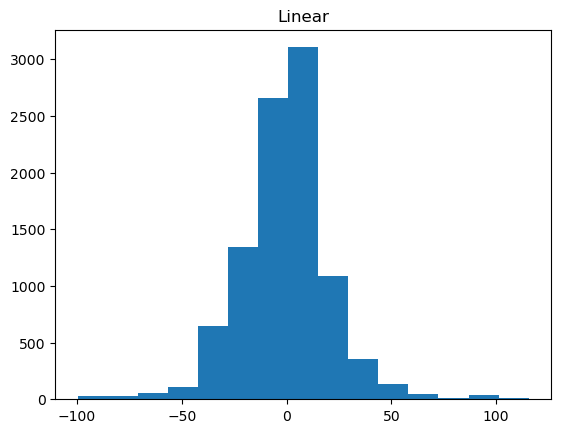

In [7]:
# Plot distribution of all anomalies
trends=['Linear']
filtered_final=pd.DataFrame()
for trend in trends:
    data_check=data_imp_anom[data_imp_anom['Trend']==trend]
    #data_check[data_check['Anomalies']==0]=np.nan
    data_check=data_check.dropna(subset='Anomalies')
    # Remove outliers
    Q1 = data_check['Anomalies'].quantile(0.25)
    Q3 = data_check['Anomalies'].quantile(0.75)
    IQR = Q3 - Q1
    # Calculate lower and upper bounds
    lower_bound = Q1 - 5 * IQR
    upper_bound = Q3 + 5 * IQR
    # Filter out outliers
    data_check = data_check[(data_check['Anomalies'] >= lower_bound) & (data_check['Anomalies'] <= upper_bound)]
    fig, ax = plt.subplots()
    ax.hist(data_check['Anomalies'], bins=15)
    ax.set_title(trend)
    #ax.set_xlim([-150, 150])
    filtered_final=filtered_final.append(data_check)

In [8]:
# Save anomalies without filtering
data_imp_anom.to_csv(os.path.join(impact_folder, 'Merged_impacts_anomalies_nofilter.csv'))

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import calendar
from statsmodels.nonparametric.smoothers_lowess import lowess
# Plot detrending and anomalies combined 
def plot_combined(trend, t, y, impvar_name, var_unit, window_frac, x, y_anom, x_values, y_pred, params, hazvar_name, municipality, rmse, p, r_squared, agg_type):
    # Set font properties
    SIZE_DEFAULT = 14
    SIZE_LARGE = 16
    plt.rc("font", family="Arial")  # controls default font
    plt.rc("font", weight="normal")  # controls default font
    plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
    plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
    plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
    plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
    plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5), dpi=300)

    # Define a color palette
    colors = ["#2B2F42", "#8D99AE", "#EF233C"]
    if trend=='Linear':
        tn = mdates.date2num(t)
        X = np.array(tn).reshape(-1, 1)
        y = np.array(y)
        polynomial_features = PolynomialFeatures(degree=1)
        X_poly = polynomial_features.fit_transform(X)
        model = LinearRegression()
        model.fit(X_poly, y)
        # Expected variable using polynomial regression
        y_trend = model.predict(X_poly)
        # Calculate annual percentages of anomaly
        y_anom = (y-y_trend)/abs(y_trend)*100
    # Plot original data and trend on ax1
    ax1.scatter(pd.to_datetime(t, format='%Y'), y, color='black', label='Original Data', s=50)
    ax1.plot(pd.to_datetime(t, format='%Y'), y_trend, linestyle='--', color='blue', label=trend+' Trend', linewidth=2)

    # Hide unnecessary spines
    ax1.spines["right"].set_visible(False)
    ax1.spines["top"].set_visible(False)

    # Set labels and title
    ax1.set_xlabel('Time', fontsize=SIZE_LARGE)
    ax1.set_ylabel(f'{impvar_name}, {var_unit}', fontsize=SIZE_LARGE)
    ax1.set_title(f'{municipality} Municipality', fontsize=SIZE_LARGE)
    ax1.legend(fontsize=SIZE_DEFAULT)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax1.tick_params(axis='both', which='major', labelsize=SIZE_DEFAULT)
    ax1.grid(False)

    # Plot the model and anomalies against hazard index on ax2
    ax2.scatter(x, y_anom, color='black', label='Original Data', s=50)
    model_str = (
        f'{params[0]:.2f}$I^3$ '
        f'{"+" if params[1] >= 0 else "-"} {abs(params[1]):.2f}$I^2$ '
        f'{"+" if params[2] >= 0 else "-"} {abs(params[2]):.2f}$I$ '
        f'{"+" if params[3] >= 0 else "-"} {abs(params[3]):.2f}')
    ax2.plot(x_values, y_pred, color=colors[2], label=model_str, linewidth=2)

    # Hide unnecessary spines
    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)

    # Set labels and title
    ax2.set_xlabel(f'Yearly maxima {hazvar_name} of {calendar.month_name[agg_type]} calendar months', fontsize=SIZE_LARGE)
    ax2.set_ylabel(f'{impvar_name} anomaly (%)', fontsize=SIZE_LARGE)
    ax2.set_title(f'{municipality} Municipality', fontsize=SIZE_LARGE)

    # Add text box with statistics
    textstr = f'$R^2$: {r_squared:.2f}, RMSE: {rmse:.2f}%\np: {p:.5f}'
    #ax2.text(0.75, 0.05, textstr, transform=ax2.transAxes, fontsize=SIZE_DEFAULT,
             #verticalalignment='bottom')
    handles, labels = ax2.get_legend_handles_labels()
    # Add custom text to labels
    labels.append(textstr)
    handles.append(plt.Line2D([0], [0], color='none'))  # Dummy handle to match the custom label
    ax2.legend(handles, labels, fontsize=SIZE_DEFAULT)
    #ax2.legend(fontsize=SIZE_DEFAULT)
    ax2.tick_params(axis='both', which='major', labelsize=SIZE_DEFAULT)
    ax2.grid(False)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.savefig('fig_example.svg', dpi=300)
    #plt.savefig('fig_example.eps', dpi=300)# Save as EPS
    plt.show()



In [12]:
# Model fitting per municipality 
from tqdm import tqdm_notebook as tqdm
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from scipy.optimize import curve_fit
from scipy.stats import f
import sys

# Define fitting model function
def poly_model(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d # third order polynomial model

impact_info=pd.read_excel('Variable List.xlsx','Impact')
hazard_info=pd.read_excel('Variable List.xlsx', 'Hazard')

# Ignore all warnings
warnings.filterwarnings('ignore')
from scipy.stats import pearsonr, linregress
import numpy as np
alpha=0.0 # R-squared threshold
c_alpha=1 # plotting alpha for scatter plots
threshold=-9999 # hazard index minimum threshold
agg_type=1 # monthly aggregation
data=read_data(agg_type)
#data = data.drop(columns=['Unnamed: 0.1'])
municipalities= data['Municipality'].unique()
# Set the parameter bounds
lower_bounds = [-10, -10, -10, -10]
upper_bounds = [10, 10, 10, 10]

def correlations(data, impact_variable, hazard_variable, threshold, trend, agg_type):
    all_count_df=pd.DataFrame()
    #all_data_pair_mun=pd.DataFrame()
    all_saved_data= pd.DataFrame()
    print(impact_variable)
    # Read impact variable data
    mun_total=impact_info[impact_info['var']==impact_variable]['Municipalities Covered'].values[0]
    var_unit=impact_info[impact_info['var']==impact_variable]['Converted Unit'].values[0]
    impvar_name=impact_info[impact_info['var']==impact_variable]['Variable Name'].values[0]
    try:
        hazvar_name=hazard_info[hazard_info['var']==hazard_variable]['Variable Name'].values[0]
    except:
        hazvar_name=hazard_variable
    print(hazard_variable)
    data_haz= data[data['Variable']==hazard_variable]
    data_haz = data_haz.drop(columns=['Anomalies', 'Trend'])
    data_haz['Value'] = pd.to_numeric(data_haz['Value'])
    
    if hazard_variable=='SPEI12':
        data_haz[data_haz['Value']>threshold]=np.nan # Apply threshold
    else:    
        data_haz[data_haz['Value']<threshold]=np.nan # Apply threshold
    data_haz=data_haz.replace(-np.inf, pd.NA).dropna(subset='Value') # remove missing data
    data_haz=data_haz.replace(np.inf, pd.NA).dropna(subset='Value') # remove missing data
    data_imp= data[data['Variable']==impact_variable]
    data_imp['Value'] = pd.to_numeric(data_imp['Value'])
    municipalities= data_imp['Municipality'].dropna().unique()
    data_imp= data_imp[data_imp['Trend']==trend]
    data_pair=data_imp.merge(data_haz, on=['Time','Municipality'])

    # Find correlations at each municipality
    corrs=[]
    pvalues=[]
    all_obs=[]
    all_pre=[]
    a_coeff=[]
    b_coeff=[]
    c_coeff=[]
    d_coeff=[]
    muns=[]
    corr_df=pd.DataFrame(columns=['Municipality', 'Correlation', 'Aggregation'])
    count_df=pd.DataFrame(columns=['Impact variable', 'Hazard variable', 'Count', 'Significance %','Threshold', 'Trend', 'Trend Parameter'])
    count_sig=0
    r2_med=np.nan
    p_value=np.nan
    with tqdm(total=(len(municipalities))) as pbar:
        for municipality in municipalities:
            #print(municipality)
            saved_data= pd.DataFrame()
            data_pair_mun= data_pair[data_pair['Municipality']==municipality]
            data_pair_mun= data_pair_mun.sort_values('Time', ascending=True)
            y = pd.to_numeric(data_pair_mun['Value_x'], errors='coerce') # impact variable
            y[y==0]=np.nan # remove data with zeroes (hydro prod for example)
            x = pd.to_numeric(data_pair_mun['Value_y'], errors='coerce') # hazard variable
            y_anom = data_pair_mun.Anomalies.values
            selected_indices = np.where((~np.isnan(x)) & (~np.isinf(x)) & (~np.isnan(y_anom)) & (~np.isinf(y_anom)))
            y = y.values[selected_indices]
            x = x.values[selected_indices]
            t = data_pair_mun.Time.values[selected_indices] # time variable
            y_anom = y_anom[selected_indices]
            if len(t)>3:
                params, covariance = curve_fit(poly_model, x, y_anom, bounds=(lower_bounds, upper_bounds))
                a, b, c, d= params
                # Generate x values to cover the entire range
                x_values = np.linspace(min(x), max(x), 100)
                # Make predictions on all x values
                y_pred = poly_model(x_values, *params)
                # Calculate R-squared and p-value
                r_squared = r2_score(y_anom, poly_model(x, *params))
                mse = mean_squared_error(y_anom, poly_model(x, *params))
                rmse = np.sqrt(mse)
                # Number of data points
                n = len(x)
                # Number of parameters in the model
                k = len(params)
                # Residual sum of squares
                y_pred2 = poly_model(x, *params)
                RSS = np.sum((y_anom - y_pred2) ** 2)
                # Calculate sum of squares due to regression (SSR) and error (SSE)
                y_mean = np.mean(y_anom)
                #y_pred = poly_model(x, *params)
                SSR = np.sum((y_pred2 - y_mean) ** 2)  # Explained variance
                SSE = np.sum((y_anom - y_pred2) ** 2)  # Unexplained variance
                # Model degrees of freedom and residual degrees of freedom
                p = 3  # Number of predictors: a, b, and c (excluding intercept)
                n = len(y_anom)
                # F-statistic
                F_stat = (SSR / p) / (SSE / (n - p - 1))
                # Compute the p-value using the F-distribution
                p_value = 1 - f.cdf(F_stat, dfn=p, dfd=n - p - 1)
                if p_value > 0.05: # not statistically significant
                    r_squared= np.nan
                else:
                    count_sig= count_sig + 1
                saved_data['Time']=t
                saved_data['Municipality']=municipality
                saved_data['Impact variable']=impact_variable
                saved_data['Hazard variable']=hazard_variable
                saved_data['Impact value']=y
                saved_data['Hazard value']=x
                saved_data['Trend']=trend
                saved_data['Observed anomalies']=y_anom
                saved_data['Predicted anomalies']=y_pred2
                saved_data['Aggregation']=agg_type
            else:
                r_squared = 0
                y_anom = np.nan
                y_pred2 = np.nan
                pvalue = np.nan
                a= np.nan
                b= np.nan
                c= np.nan
                d= np.nan
            all_obs.append(y_anom)
            all_pre.append(y_pred2)
            muns.append(municipality)
            corrs.append(r_squared)
            pbar.update(1)
            d_coeff.append(d)
            c_coeff.append(c)
            b_coeff.append(b)
            a_coeff.append(a)
            pvalues.append(p_value)
            all_saved_data=all_saved_data.append(saved_data)
        counts=count_sig
        # Correlation df: information for each municipality
        corr_df['Municipality']=muns
        corr_df['Correlation']=corrs
        corr_df['p']=pvalues
        corr_df['Aggregation']=agg_type
        corr_df['Trend']=trend
        corr_df['Impact variable']=impact_variable
        corr_df['Hazard variable']=hazard_variable
        corr_df['A']=a_coeff
        corr_df['B']=b_coeff
        corr_df['C']=c_coeff
        corr_df['D']=d_coeff
        corrs=np.array(corrs)
        r2_avg=np.nanmean(corrs[corrs>0])
        r2_med=np.nanmedian(corrs[corrs>0])
        count_df['Count']=[counts]
        count_df['Impact variable']=impact_variable
        count_df['Hazard variable']=hazard_variable
        count_df['Significance %']=np.round(count_sig/mun_total*100,2)
        count_df['Mean R2']=r2_avg
        count_df['Threshold']=threshold
        count_df['Trend']=trend
        count_df['Aggregation']=agg_type
        print(count_df)
        all_count_df=all_count_df.append(count_df)
    return corr_df, all_count_df, np.round(r2_avg,2), np.round(r2_med,2), count_sig, all_saved_data
                    

Hazard variable: SPEI12
Impact variable: crop_yield_total
Aggregation type: 1
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
SPEI12


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total          SPEI12      7            2.41        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.482864            1  
Hazard variable: HWI
Impact variable: crop_yield_total
Aggregation type: 1
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
HWI


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total             HWI      0             0.0        NaN  Linear   

  Trend Parameter  Mean R2  Aggregation  
0             NaN      NaN            1  
Hazard variable: DFI
Impact variable: crop_yield_total
Aggregation type: 1
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
DFI


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total             DFI     16            5.52        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.507424            1  
Hazard variable: SPEI12
Impact variable: crop_yield_total
Aggregation type: 2
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
SPEI12


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total          SPEI12     23            7.93        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.508656            2  
Hazard variable: HWI
Impact variable: crop_yield_total
Aggregation type: 2
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
HWI


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total             HWI     61           21.03        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.522247            2  
Hazard variable: DFI
Impact variable: crop_yield_total
Aggregation type: 2
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
DFI


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total             DFI      0             0.0        NaN  Linear   

  Trend Parameter  Mean R2  Aggregation  
0             NaN      NaN            2  
Hazard variable: SPEI12
Impact variable: crop_yield_total
Aggregation type: 3
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
SPEI12


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total          SPEI12     12            4.14        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.527593            3  
Hazard variable: HWI
Impact variable: crop_yield_total
Aggregation type: 3
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
HWI


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total             HWI     62           21.38        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.584476            3  
Hazard variable: DFI
Impact variable: crop_yield_total
Aggregation type: 3
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
DFI


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total             DFI      0             0.0        NaN  Linear   

  Trend Parameter  Mean R2  Aggregation  
0             NaN      NaN            3  
Hazard variable: SPEI12
Impact variable: crop_yield_total
Aggregation type: 4
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
SPEI12


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total          SPEI12     12            4.14        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.555967            4  
Hazard variable: HWI
Impact variable: crop_yield_total
Aggregation type: 4
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
HWI


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total             HWI     25            8.62        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.535036            4  
Hazard variable: DFI
Impact variable: crop_yield_total
Aggregation type: 4
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
DFI


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total             DFI      0             0.0        NaN  Linear   

  Trend Parameter  Mean R2  Aggregation  
0             NaN      NaN            4  
Hazard variable: SPEI12
Impact variable: crop_yield_total
Aggregation type: 5
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
SPEI12


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total          SPEI12      9             3.1        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.485908            5  
Hazard variable: HWI
Impact variable: crop_yield_total
Aggregation type: 5
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
HWI


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total             HWI      4            1.38        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.471702            5  
Hazard variable: DFI
Impact variable: crop_yield_total
Aggregation type: 5
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
DFI


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total             DFI      0             0.0        NaN  Linear   

  Trend Parameter  Mean R2  Aggregation  
0             NaN      NaN            5  
Hazard variable: SPEI12
Impact variable: crop_yield_total
Aggregation type: 6
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
SPEI12


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total          SPEI12      0             0.0        NaN  Linear   

  Trend Parameter  Mean R2  Aggregation  
0             NaN      NaN            6  
Hazard variable: HWI
Impact variable: crop_yield_total
Aggregation type: 6
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
HWI


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total             HWI     20             6.9        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.642992            6  
Hazard variable: DFI
Impact variable: crop_yield_total
Aggregation type: 6
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
DFI


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total             DFI     26            8.97        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.531803            6  
Hazard variable: SPEI12
Impact variable: crop_yield_total
Aggregation type: 7
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
SPEI12


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total          SPEI12      0             0.0        NaN  Linear   

  Trend Parameter  Mean R2  Aggregation  
0             NaN      NaN            7  
Hazard variable: HWI
Impact variable: crop_yield_total
Aggregation type: 7
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
HWI


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total             HWI     13            4.48        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.453577            7  
Hazard variable: DFI
Impact variable: crop_yield_total
Aggregation type: 7
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
DFI


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total             DFI     47           16.21        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.721865            7  
Hazard variable: SPEI12
Impact variable: crop_yield_total
Aggregation type: 8
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
SPEI12


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total          SPEI12      0             0.0        NaN  Linear   

  Trend Parameter  Mean R2  Aggregation  
0             NaN      NaN            8  
Hazard variable: HWI
Impact variable: crop_yield_total
Aggregation type: 8
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
HWI


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total             HWI     27            9.31        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.554392            8  
Hazard variable: DFI
Impact variable: crop_yield_total
Aggregation type: 8
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
DFI


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total             DFI      2            0.69        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.560417            8  
Hazard variable: SPEI12
Impact variable: crop_yield_total
Aggregation type: 9
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
SPEI12


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total          SPEI12      0             0.0        NaN  Linear   

  Trend Parameter  Mean R2  Aggregation  
0             NaN      NaN            9  
Hazard variable: HWI
Impact variable: crop_yield_total
Aggregation type: 9
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
HWI


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total             HWI      5            1.72        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.864415            9  
Hazard variable: DFI
Impact variable: crop_yield_total
Aggregation type: 9
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
DFI


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total             DFI     23            7.93        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.581439            9  
Hazard variable: SPEI12
Impact variable: crop_yield_total
Aggregation type: 10
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
SPEI12


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total          SPEI12      8            2.76        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.554877           10  
Hazard variable: HWI
Impact variable: crop_yield_total
Aggregation type: 10
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
HWI


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total             HWI      9             3.1        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.567897           10  
Hazard variable: DFI
Impact variable: crop_yield_total
Aggregation type: 10
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
DFI


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total             DFI     20             6.9        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.577767           10  
Hazard variable: SPEI12
Impact variable: crop_yield_total
Aggregation type: 11
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
SPEI12


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total          SPEI12     39           13.45        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.505071           11  
Hazard variable: HWI
Impact variable: crop_yield_total
Aggregation type: 11
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
HWI


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total             HWI      0             0.0        NaN  Linear   

  Trend Parameter  Mean R2  Aggregation  
0             NaN      NaN           11  
Hazard variable: DFI
Impact variable: crop_yield_total
Aggregation type: 11
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
DFI


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total             DFI     40           13.79        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.622977           11  
Hazard variable: SPEI12
Impact variable: crop_yield_total
Aggregation type: 12
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
SPEI12


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total          SPEI12     53           18.28        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.507928           12  
Hazard variable: HWI
Impact variable: crop_yield_total
Aggregation type: 12
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
HWI


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total             HWI      0             0.0        NaN  Linear   

  Trend Parameter  Mean R2  Aggregation  
0             NaN      NaN           12  
Hazard variable: DFI
Impact variable: crop_yield_total
Aggregation type: 12
Threshold type: none
Trend: Linear
Threshold: nan
crop_yield_total
DFI


  0%|          | 0/246 [00:00<?, ?it/s]

    Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0  crop_yield_total             DFI     21            7.24        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.530713           12  


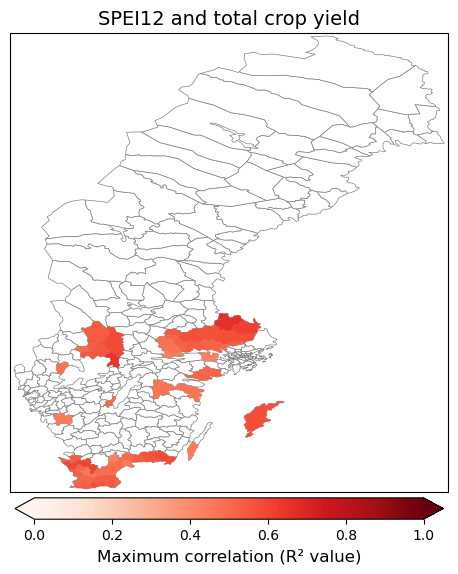

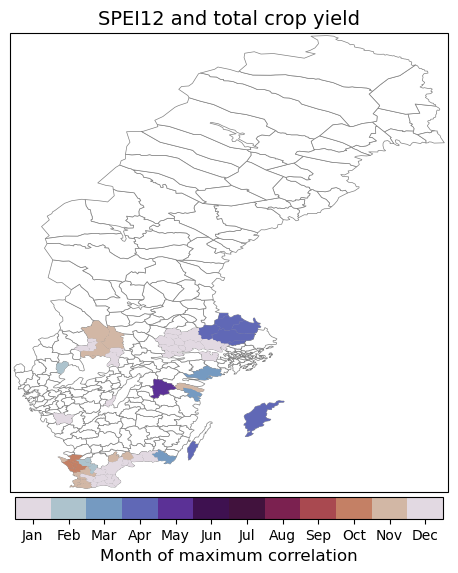

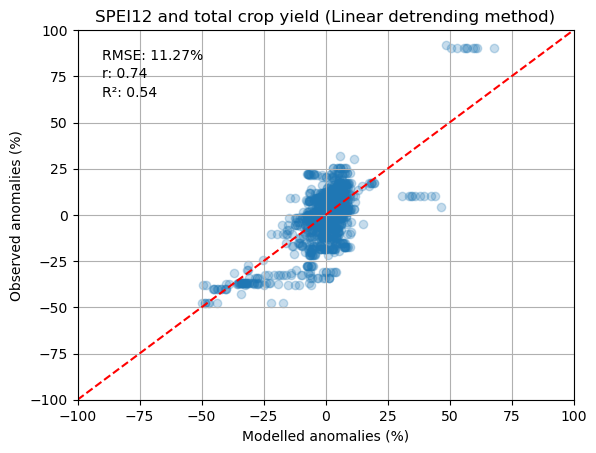

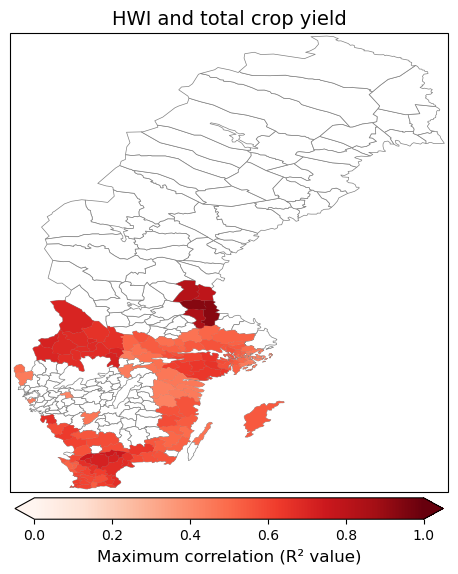

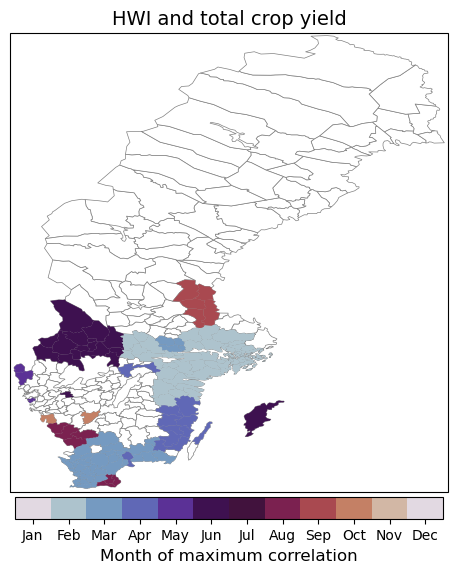

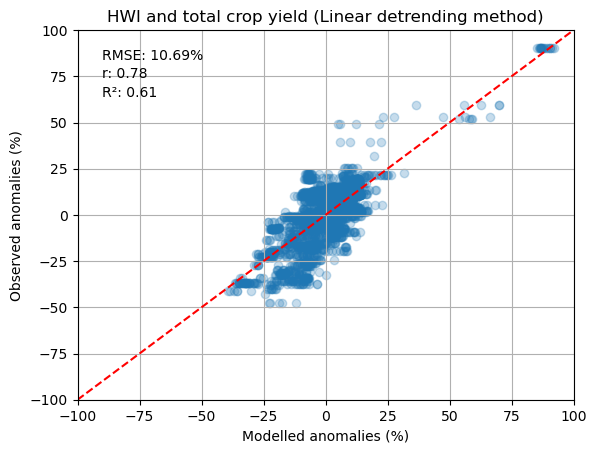

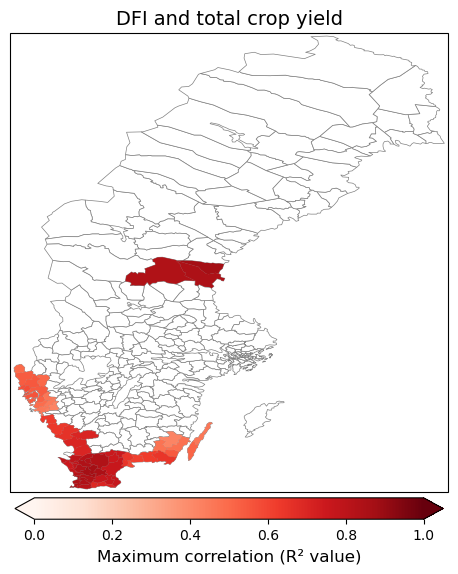

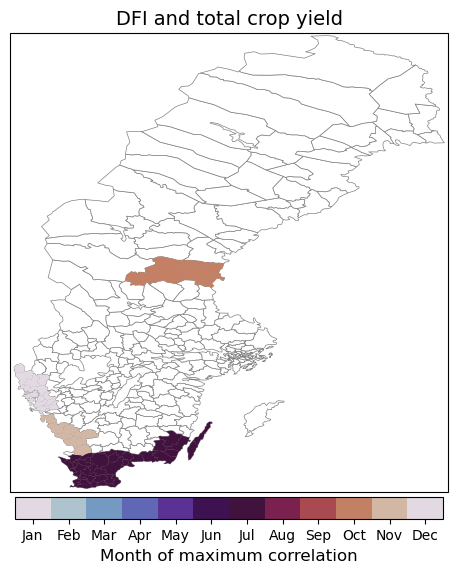

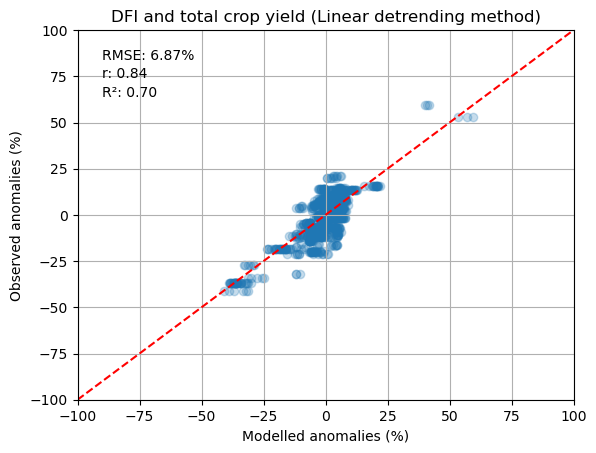

In [13]:
# Batch Runs - Food
runs_df=pd.read_excel('Variable Runs Municipality.xlsx',
                         'Food')
runs_df=runs_df.sort_values('hazard_var', ascending=False)
runs_df=runs_df[runs_df['Threshold Type']=='none']
all_corr_df=pd.DataFrame()
all_count_df=pd.DataFrame()
all_saved_data=pd.DataFrame()
trends=['Linear']
runs_df['Count']=np.nan
runs_df['Trend']=np.nan
runs_df['Median R2']=np.nan
runs_df['Aggregation']=1
runs_no_trend=runs_df.copy()
for trend in trends:
    runs_df_trend=runs_no_trend.copy()
    runs_df_trend['Trend']=trend
    runs_df=runs_df.append(runs_df_trend)
runs_df=runs_df.dropna(subset='Trend')
months=[2,3,4,5,6,7,8,9,10,11,12]
runs_no_month=runs_df.copy()
for month in months:
    runs_df_month=runs_no_month.copy()
    runs_df_month['Aggregation']=month
    runs_df=runs_df.append(runs_df_month)
for N in range(len(runs_df)):
    trend= runs_df['Trend'].iloc[N]
    var_imp= runs_df['impact_var'].iloc[N]
    var_haz= runs_df['hazard_var'].iloc[N]
    conversion= runs_df['Conversion'].iloc[N]
    threshold= runs_df['Threshold'].iloc[N]
    t_type= runs_df['Threshold Type'].iloc[N]
    #threshold=0
    agg_type= runs_df['Aggregation'].iloc[N]
    data=read_data(agg_type)
    #agg_type= 'mean'
    print('Hazard variable: '+var_haz)
    print('Impact variable: '+var_imp)
    print('Aggregation type: '+str(agg_type))
    print('Threshold type: '+str(t_type))
    print('Trend: '+str(trend))
    print('Threshold: '+str(threshold))
    corr_df, count_df, mean_r2, median_r2, count, saved_data = correlations(data, var_imp, var_haz, threshold, trend, agg_type)
    runs_df['Mean R2'].iloc[N]=mean_r2
    runs_df['Median R2'].iloc[N]=median_r2
    runs_df['Count'].iloc[N]=count # number of municipality with statistically significant results
    all_corr_df=all_corr_df.append(corr_df)
    all_saved_data=all_saved_data.append(saved_data)
    all_count_df=all_count_df.append(count_df)
runs_df.to_excel('Runs_food_municipalities_months.xlsx')
all_saved_data.to_csv('Results_food_municipalities_months.csv')
all_corr_df.to_excel('All_correlations_food_municipalities_months.xlsx')
# Plot graphs of maximum correlations
max_df=pd.DataFrame()
max_df['R2 overall']=np.nan
max_df['RMSE overall']=np.nan
r_squared_list=[]
r_list=[]
p_list=[]
rmse_list=[]
hazvar_list=[]
impvar_list=[]
trend_list=[]
for trend in all_count_df['Trend'].unique():
    for hazvar in all_count_df['Hazard variable'].unique():
        for impvar in all_count_df['Impact variable'].unique():
            hazvar_list.append(hazvar)
            impvar_list.append(impvar)
            trend_list.append(trend)
           # Select all correlations for all municipalities and months by hazard pair and trend type 
            all_corr_df_var=all_corr_df[all_corr_df['Hazard variable']==hazvar]
            all_corr_df_var=all_corr_df_var[all_corr_df_var['Impact variable']==impvar]
            all_corr_df_var=all_corr_df_var[all_corr_df_var['Trend']==trend]
            # Find maximum correlations by month 
            max_corr_agg = all_corr_df_var.groupby(['Municipality','Impact variable', 'Hazard variable', 'Trend']).agg('max').reset_index()
            max_corr_agg = max_corr_agg[max_corr_agg['Correlation']>0]
            # Drop Aggregation Column from max_corr_agg
            max_corr_agg.drop(columns=['Aggregation', 'A', 'B', 'C', 'D', 'p'], inplace=True)
            # Merge max_corr_agg with all_corr_df based on Correlation and Municipality to obtain corresponding Aggregation with maximum correlation
            max_corr_agg = pd.merge(max_corr_agg, all_corr_df, on=['Municipality', 'Impact variable', 'Hazard variable', 'Correlation', 'Trend'], how='left')
            corr_gdf = pd.merge(kommun_shapefile, max_corr_agg, left_on='KnNamn', right_on='Municipality')
            # Next, retrieve yearly impacts based on month with highest correlation 
            max_data= pd.merge(max_corr_agg, all_saved_data, on=['Municipality', 'Impact variable', 'Hazard variable', 'Aggregation', 'Trend'], how='left')
            impvar_name=impact_info[impact_info['var']==impvar]['Variable Name'].values[0]
            hazvar_name=hazard_info[hazard_info['var']==hazvar]['Variable Name'].values[0]
            title= hazvar_name +' and ' + impvar_name.lower()
            plot_map(corr_gdf, 'Correlation', title, 'Maximum correlation (R² value)',
                     lower_bound=0, upper_bound=1, 
                     vcenter=0, cmap_type='Reds', save='no', filename='r2_map_corrs')
            plot_map_months(corr_gdf, 'Aggregation', title, 'Month of maximum correlation',
                     lower_bound=1, upper_bound=13, 
                     vcenter=0, cmap_type='Reds', save='no', filename='r2_map_months')

            # Sample data
            predicted_anomalies = max_data['Predicted anomalies']
            observed_anomalies = max_data['Observed anomalies']
            
            # Step 1: Filter out anomalies that are too large or too low
            predicted_anomalies = np.where((predicted_anomalies > 100) | (predicted_anomalies < -100), np.nan, predicted_anomalies)
            observed_anomalies = np.where((observed_anomalies > 100) | (observed_anomalies < -100), np.nan, observed_anomalies)

            # Step 2: Create a mask for indices where both arrays are non-NaN
            valid_mask = ~np.isnan(predicted_anomalies) & ~np.isnan(observed_anomalies)

            # Step 3: Filter both arrays using the mask
            predicted_anomalies = predicted_anomalies[valid_mask]
            observed_anomalies = observed_anomalies[valid_mask]

            # Calculate mean root square error and R-squared
            r_squared = r2_score(observed_anomalies, predicted_anomalies)
            r_squared_list.append(r_squared)
            r, p_value = pearsonr(observed_anomalies, predicted_anomalies)
            r_list.append(r)
            p_list.append(p_value)
            #print("R-squared:", r_squared)
            mse = mean_squared_error(observed_anomalies, predicted_anomalies)
            rmse = np.sqrt(mse)
            rmse_list.append(rmse)
            # Define limits
            limit = (-100, 100)

            # Plot scatter with transparency
            plt.scatter(predicted_anomalies, observed_anomalies, alpha=0.25)
            plt.xlim(limit)
            plt.ylim(limit)
            plt.xlabel('Modelled anomalies (%)')
            plt.ylabel('Observed anomalies (%)')
            plt.title(title+' ('+trend+' detrending method)')
            # Plot diagonal line
            plt.plot(limit, limit, color='red', linestyle='--')

            # Add text boxes for mean root square error and R-squared
            plt.text(0.05, 0.95, f'RMSE: {rmse:.2f}%', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
            plt.text(0.05, 0.90, f'r: {r:.2f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
            plt.text(0.05, 0.85, f'R²: {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
            plt.grid(True)
            plt.show()

# Save results
max_df['Impact variable']=impvar_list
max_df['Hazard variable']=hazvar_list
max_df['Trend']=trend_list
max_df['R2 overall']=r_squared_list
max_df['R overall']=r_list
max_df['RMSE overall']=rmse_list
max_df['p overall']=p_list
max_df.to_excel('Correlations_food_municipalities_months.xlsx')

Hazard variable: SPEI12
Impact variable: discharge
Aggregation type: 1
Threshold type: none
Trend: Linear
Threshold: nan
discharge
SPEI12


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge          SPEI12      0             0.0        NaN  Linear   

  Trend Parameter  Mean R2  Aggregation  
0             NaN      NaN            1  
Hazard variable: HWI
Impact variable: discharge
Aggregation type: 1
Threshold type: none
Trend: Linear
Threshold: nan
discharge
HWI


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge             HWI      2            1.02        NaN  Linear   

  Trend Parameter  Mean R2  Aggregation  
0             NaN  0.53608            1  
Hazard variable: DFI
Impact variable: discharge
Aggregation type: 1
Threshold type: none
Trend: Linear
Threshold: nan
discharge
DFI


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge             DFI      3            1.52        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.634963            1  
Hazard variable: SPEI12
Impact variable: discharge
Aggregation type: 2
Threshold type: none
Trend: Linear
Threshold: nan
discharge
SPEI12


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge          SPEI12      1            0.51        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.523582            2  
Hazard variable: HWI
Impact variable: discharge
Aggregation type: 2
Threshold type: none
Trend: Linear
Threshold: nan
discharge
HWI


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge             HWI      5            2.54        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.472838            2  
Hazard variable: DFI
Impact variable: discharge
Aggregation type: 2
Threshold type: none
Trend: Linear
Threshold: nan
discharge
DFI


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge             DFI      5            2.54        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.596865            2  
Hazard variable: SPEI12
Impact variable: discharge
Aggregation type: 3
Threshold type: none
Trend: Linear
Threshold: nan
discharge
SPEI12


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge          SPEI12      0             0.0        NaN  Linear   

  Trend Parameter  Mean R2  Aggregation  
0             NaN      NaN            3  
Hazard variable: HWI
Impact variable: discharge
Aggregation type: 3
Threshold type: none
Trend: Linear
Threshold: nan
discharge
HWI


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge             HWI     11            5.58        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.504336            3  
Hazard variable: DFI
Impact variable: discharge
Aggregation type: 3
Threshold type: none
Trend: Linear
Threshold: nan
discharge
DFI


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge             DFI      0             0.0        NaN  Linear   

  Trend Parameter  Mean R2  Aggregation  
0             NaN      NaN            3  
Hazard variable: SPEI12
Impact variable: discharge
Aggregation type: 4
Threshold type: none
Trend: Linear
Threshold: nan
discharge
SPEI12


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge          SPEI12      1            0.51        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.499767            4  
Hazard variable: HWI
Impact variable: discharge
Aggregation type: 4
Threshold type: none
Trend: Linear
Threshold: nan
discharge
HWI


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge             HWI      2            1.02        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.496366            4  
Hazard variable: DFI
Impact variable: discharge
Aggregation type: 4
Threshold type: none
Trend: Linear
Threshold: nan
discharge
DFI


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge             DFI      6            3.05        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.574292            4  
Hazard variable: SPEI12
Impact variable: discharge
Aggregation type: 5
Threshold type: none
Trend: Linear
Threshold: nan
discharge
SPEI12


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge          SPEI12      0             0.0        NaN  Linear   

  Trend Parameter  Mean R2  Aggregation  
0             NaN      NaN            5  
Hazard variable: HWI
Impact variable: discharge
Aggregation type: 5
Threshold type: none
Trend: Linear
Threshold: nan
discharge
HWI


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge             HWI      8            4.06        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.518118            5  
Hazard variable: DFI
Impact variable: discharge
Aggregation type: 5
Threshold type: none
Trend: Linear
Threshold: nan
discharge
DFI


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge             DFI      9            4.57        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.548289            5  
Hazard variable: SPEI12
Impact variable: discharge
Aggregation type: 6
Threshold type: none
Trend: Linear
Threshold: nan
discharge
SPEI12


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge          SPEI12      5            2.54        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.506136            6  
Hazard variable: HWI
Impact variable: discharge
Aggregation type: 6
Threshold type: none
Trend: Linear
Threshold: nan
discharge
HWI


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge             HWI      4            2.03        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.475437            6  
Hazard variable: DFI
Impact variable: discharge
Aggregation type: 6
Threshold type: none
Trend: Linear
Threshold: nan
discharge
DFI


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge             DFI      4            2.03        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.472428            6  
Hazard variable: SPEI12
Impact variable: discharge
Aggregation type: 7
Threshold type: none
Trend: Linear
Threshold: nan
discharge
SPEI12


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge          SPEI12     10            5.08        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.535237            7  
Hazard variable: HWI
Impact variable: discharge
Aggregation type: 7
Threshold type: none
Trend: Linear
Threshold: nan
discharge
HWI


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge             HWI      2            1.02        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.503857            7  
Hazard variable: DFI
Impact variable: discharge
Aggregation type: 7
Threshold type: none
Trend: Linear
Threshold: nan
discharge
DFI


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge             DFI     12            6.09        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.544948            7  
Hazard variable: SPEI12
Impact variable: discharge
Aggregation type: 8
Threshold type: none
Trend: Linear
Threshold: nan
discharge
SPEI12


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge          SPEI12     33           16.75        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.546832            8  
Hazard variable: HWI
Impact variable: discharge
Aggregation type: 8
Threshold type: none
Trend: Linear
Threshold: nan
discharge
HWI


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge             HWI      0             0.0        NaN  Linear   

  Trend Parameter  Mean R2  Aggregation  
0             NaN      NaN            8  
Hazard variable: DFI
Impact variable: discharge
Aggregation type: 8
Threshold type: none
Trend: Linear
Threshold: nan
discharge
DFI


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge             DFI     29           14.72        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.518335            8  
Hazard variable: SPEI12
Impact variable: discharge
Aggregation type: 9
Threshold type: none
Trend: Linear
Threshold: nan
discharge
SPEI12


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge          SPEI12     48           24.37        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.566509            9  
Hazard variable: HWI
Impact variable: discharge
Aggregation type: 9
Threshold type: none
Trend: Linear
Threshold: nan
discharge
HWI


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge             HWI      1            0.51        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.444603            9  
Hazard variable: DFI
Impact variable: discharge
Aggregation type: 9
Threshold type: none
Trend: Linear
Threshold: nan
discharge
DFI


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge             DFI     47           23.86        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.551479            9  
Hazard variable: SPEI12
Impact variable: discharge
Aggregation type: 10
Threshold type: none
Trend: Linear
Threshold: nan
discharge
SPEI12


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge          SPEI12     63           31.98        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.590611           10  
Hazard variable: HWI
Impact variable: discharge
Aggregation type: 10
Threshold type: none
Trend: Linear
Threshold: nan
discharge
HWI


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge             HWI      1            0.51        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.457633           10  
Hazard variable: DFI
Impact variable: discharge
Aggregation type: 10
Threshold type: none
Trend: Linear
Threshold: nan
discharge
DFI


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge             DFI     48           24.37        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.574487           10  
Hazard variable: SPEI12
Impact variable: discharge
Aggregation type: 11
Threshold type: none
Trend: Linear
Threshold: nan
discharge
SPEI12


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge          SPEI12     89           45.18        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.627379           11  
Hazard variable: HWI
Impact variable: discharge
Aggregation type: 11
Threshold type: none
Trend: Linear
Threshold: nan
discharge
HWI


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge             HWI      5            2.54        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.573928           11  
Hazard variable: DFI
Impact variable: discharge
Aggregation type: 11
Threshold type: none
Trend: Linear
Threshold: nan
discharge
DFI


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge             DFI     19            9.64        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.577107           11  
Hazard variable: SPEI12
Impact variable: discharge
Aggregation type: 12
Threshold type: none
Trend: Linear
Threshold: nan
discharge
SPEI12


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge          SPEI12     88           44.67        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.623658           12  
Hazard variable: HWI
Impact variable: discharge
Aggregation type: 12
Threshold type: none
Trend: Linear
Threshold: nan
discharge
HWI


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge             HWI      6            3.05        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.490777           12  
Hazard variable: DFI
Impact variable: discharge
Aggregation type: 12
Threshold type: none
Trend: Linear
Threshold: nan
discharge
DFI


  0%|          | 0/124 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0       discharge             DFI     14            7.11        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.547195           12  


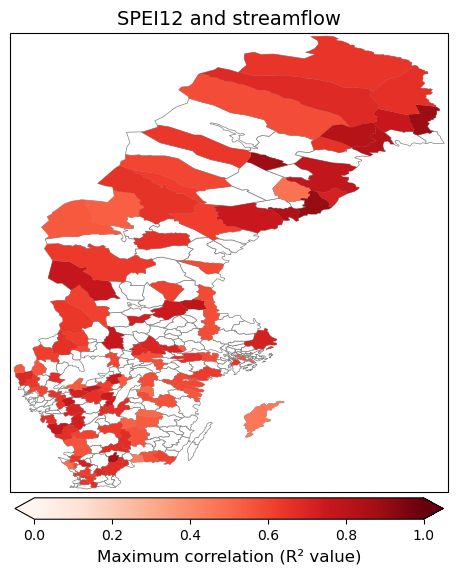

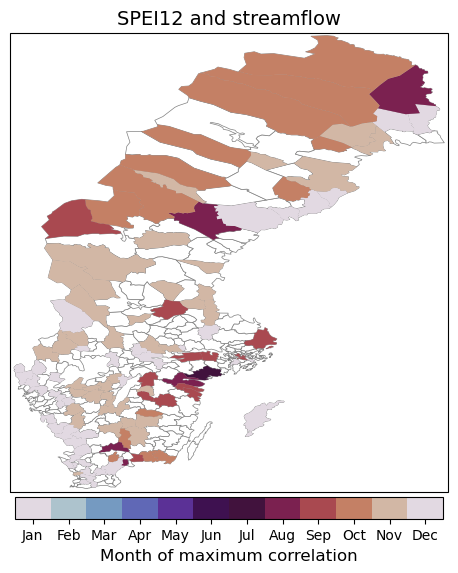

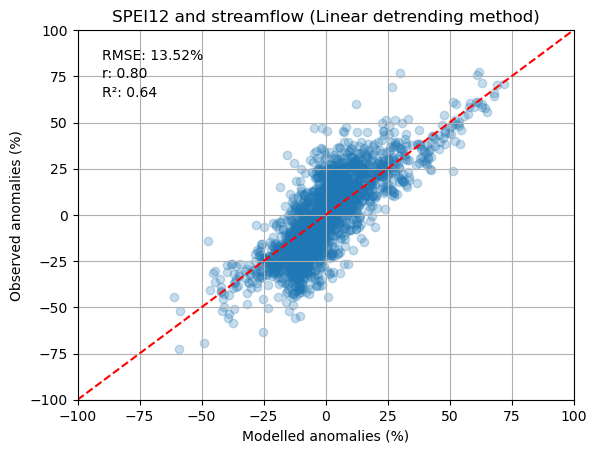

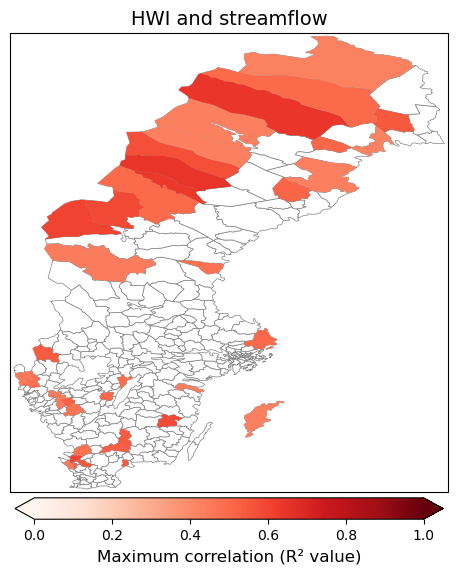

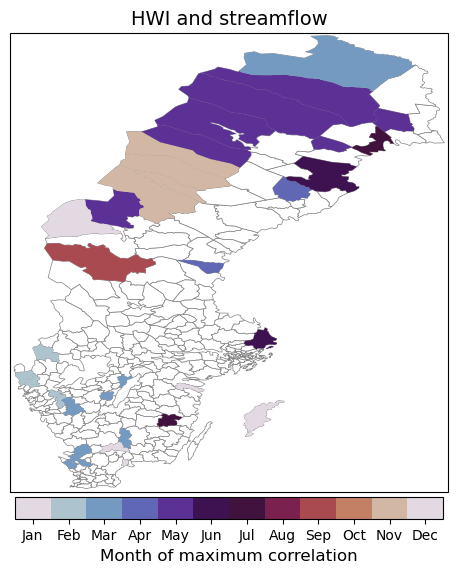

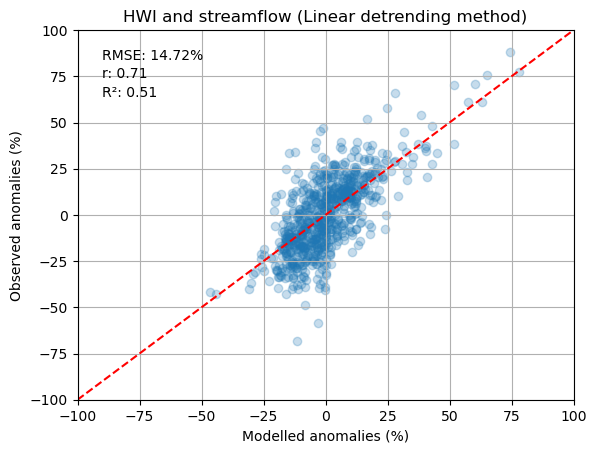

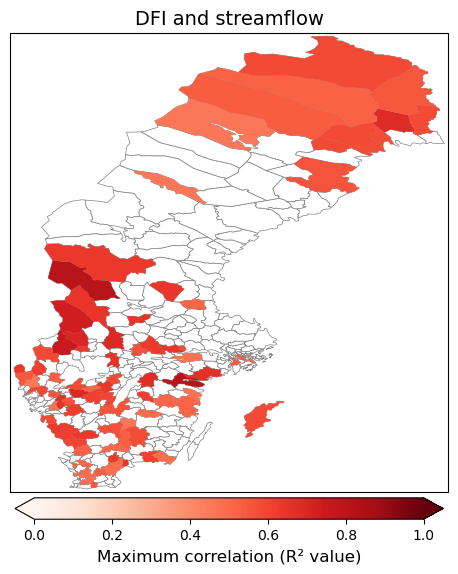

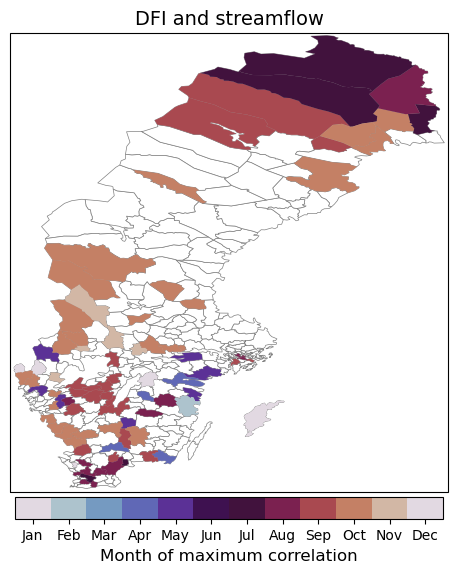

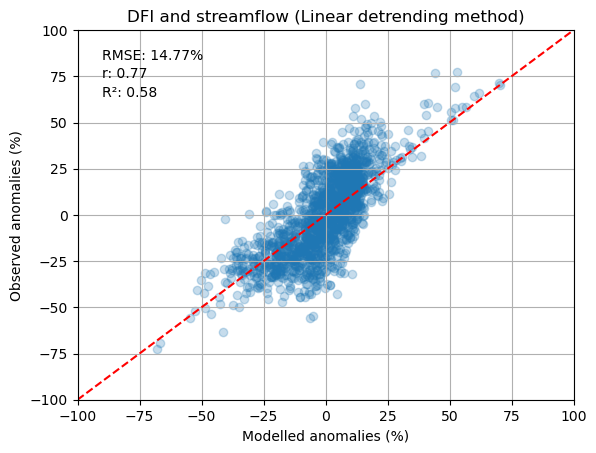

In [14]:
# Batch Runs - Water
runs_df=pd.read_excel('Variable Runs Municipality.xlsx','Water')
runs_df=runs_df.sort_values('hazard_var', ascending=False)
runs_df=runs_df[runs_df['Threshold Type']=='none']
all_corr_df=pd.DataFrame()
all_count_df=pd.DataFrame()
all_saved_data=pd.DataFrame()
trends=['Linear']
runs_df['Count']=np.nan
runs_df['Trend']=np.nan
runs_df['Median R2']=np.nan
runs_df['Aggregation']=1
runs_no_trend=runs_df.copy()
for trend in trends:
    runs_df_trend=runs_no_trend.copy()
    runs_df_trend['Trend']=trend
    runs_df=runs_df.append(runs_df_trend)
runs_df=runs_df.dropna(subset='Trend')
months=[2,3,4,5,6,7,8,9,10,11,12]
runs_no_month=runs_df.copy()
for month in months:
    runs_df_month=runs_no_month.copy()
    runs_df_month['Aggregation']=month
    runs_df=runs_df.append(runs_df_month)
for N in range(len(runs_df)):
    trend= runs_df['Trend'].iloc[N]
    var_imp= runs_df['impact_var'].iloc[N]
    var_haz= runs_df['hazard_var'].iloc[N]
    conversion= runs_df['Conversion'].iloc[N]
    threshold= runs_df['Threshold'].iloc[N]
    t_type= runs_df['Threshold Type'].iloc[N]
    #threshold=0
    agg_type= runs_df['Aggregation'].iloc[N]
    data=read_data(agg_type)
    #agg_type= 'mean'
    print('Hazard variable: '+var_haz)
    print('Impact variable: '+var_imp)
    print('Aggregation type: '+str(agg_type))
    print('Threshold type: '+str(t_type))
    print('Trend: '+str(trend))
    print('Threshold: '+str(threshold))
    corr_df, count_df, mean_r2, median_r2, count, saved_data = correlations(data, var_imp, var_haz, threshold, trend, agg_type)
    runs_df['Mean R2'].iloc[N]=mean_r2
    runs_df['Median R2'].iloc[N]=median_r2
    runs_df['Count'].iloc[N]=count # number of municipality with statistically significant results
    all_corr_df=all_corr_df.append(corr_df)
    all_saved_data=all_saved_data.append(saved_data)
    all_count_df=all_count_df.append(count_df)
runs_df.to_excel('Runs_water_municipalities_months.xlsx')
all_saved_data.to_csv('Results_water_municipalities_months.csv')
all_corr_df.to_excel('All_correlations_water_municipalities_months.xlsx')
# Plot graphs of maximum correlations
max_df=pd.DataFrame()
max_df['R2 overall']=np.nan
max_df['RMSE overall']=np.nan
r_squared_list=[]
r_list=[]
p_list=[]
rmse_list=[]
hazvar_list=[]
impvar_list=[]
trend_list=[]
for trend in all_count_df['Trend'].unique():
    for hazvar in all_count_df['Hazard variable'].unique():
        for impvar in all_count_df['Impact variable'].unique():
            hazvar_list.append(hazvar)
            impvar_list.append(impvar)
            trend_list.append(trend)
           # Select all correlations for all municipalities and months by hazard pair and trend type 
            all_corr_df_var=all_corr_df[all_corr_df['Hazard variable']==hazvar]
            all_corr_df_var=all_corr_df_var[all_corr_df_var['Impact variable']==impvar]
            all_corr_df_var=all_corr_df_var[all_corr_df_var['Trend']==trend]
            # Find maximum correlations by month 
            max_corr_agg = all_corr_df_var.groupby(['Municipality','Impact variable', 'Hazard variable', 'Trend']).agg('max').reset_index()
            max_corr_agg = max_corr_agg[max_corr_agg['Correlation']>0]
            # Drop Aggregation Column from max_corr_agg
            max_corr_agg.drop(columns=['Aggregation', 'A', 'B', 'C', 'D', 'p'], inplace=True)
            # Merge max_corr_agg with all_corr_df based on Correlation and Municipality to obtain corresponding Aggregation with maximum correlation
            max_corr_agg = pd.merge(max_corr_agg, all_corr_df, on=['Municipality', 'Impact variable', 'Hazard variable', 'Correlation', 'Trend'], how='left')
            corr_gdf = pd.merge(kommun_shapefile, max_corr_agg, left_on='KnNamn', right_on='Municipality')
            # Next, retrieve yearly impacts based on month with highest correlation 
            max_data= pd.merge(max_corr_agg, all_saved_data, on=['Municipality', 'Impact variable', 'Hazard variable', 'Aggregation', 'Trend'], how='left')
            impvar_name=impact_info[impact_info['var']==impvar]['Variable Name'].values[0]
            hazvar_name=hazard_info[hazard_info['var']==hazvar]['Variable Name'].values[0]
            title= hazvar_name +' and ' + impvar_name.lower()
            plot_map(corr_gdf, 'Correlation', title, 'Maximum correlation (R² value)',
                     lower_bound=0, upper_bound=1, 
                     vcenter=0, cmap_type='Reds', save='no', filename='r2_map_corrs')
            plot_map_months(corr_gdf, 'Aggregation', title, 'Month of maximum correlation',
                     lower_bound=1, upper_bound=13, 
                     vcenter=0, cmap_type='Reds', save='no', filename='r2_map_months')

            # Sample data
            predicted_anomalies = max_data['Predicted anomalies']
            observed_anomalies = max_data['Observed anomalies']
            
            # Step 1: Filter out anomalies that are too large or too low
            predicted_anomalies = np.where((predicted_anomalies > 100) | (predicted_anomalies < -100), np.nan, predicted_anomalies)
            observed_anomalies = np.where((observed_anomalies > 100) | (observed_anomalies < -100), np.nan, observed_anomalies)

            # Step 2: Create a mask for indices where both arrays are non-NaN
            valid_mask = ~np.isnan(predicted_anomalies) & ~np.isnan(observed_anomalies)

            # Step 3: Filter both arrays using the mask
            predicted_anomalies = predicted_anomalies[valid_mask]
            observed_anomalies = observed_anomalies[valid_mask]

            # Calculate mean root square error and R-squared
            r_squared = r2_score(observed_anomalies, predicted_anomalies)
            r_squared_list.append(r_squared)
            r, p_value = pearsonr(observed_anomalies, predicted_anomalies)
            r_list.append(r)
            p_list.append(p_value)
            #print("R-squared:", r_squared)
            mse = mean_squared_error(observed_anomalies, predicted_anomalies)
            rmse = np.sqrt(mse)
            rmse_list.append(rmse)
            # Define limits
            limit = (-100, 100)

            # Plot scatter with transparency
            plt.scatter(predicted_anomalies, observed_anomalies, alpha=0.25)
            plt.xlim(limit)
            plt.ylim(limit)
            plt.xlabel('Modelled anomalies (%)')
            plt.ylabel('Observed anomalies (%)')
            plt.title(title+' ('+trend+' detrending method)')
            # Plot diagonal line
            plt.plot(limit, limit, color='red', linestyle='--')

            # Add text boxes for mean root square error and R-squared
            plt.text(0.05, 0.95, f'RMSE: {rmse:.2f}%', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
            plt.text(0.05, 0.90, f'r: {r:.2f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
            plt.text(0.05, 0.85, f'R²: {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
            plt.grid(True)
            plt.show()

# Save results
max_df['Impact variable']=impvar_list
max_df['Hazard variable']=hazvar_list
max_df['Trend']=trend_list
max_df['R2 overall']=r_squared_list
max_df['R overall']=r_list
max_df['RMSE overall']=rmse_list
max_df['p overall']=p_list
max_df.to_excel('Correlations_water_municipalities_months.xlsx')

Hazard variable: SPEI12
Impact variable: hydro_prod
Aggregation type: 1
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
SPEI12


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod          SPEI12      1            0.51        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.489143            1  
Hazard variable: HWI
Impact variable: hydro_prod
Aggregation type: 1
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
HWI


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod             HWI     10            5.08        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.580643            1  
Hazard variable: DFI
Impact variable: hydro_prod
Aggregation type: 1
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
DFI


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod             DFI      3            1.52        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.473069            1  
Hazard variable: SPEI12
Impact variable: hydro_prod
Aggregation type: 2
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
SPEI12


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod          SPEI12      1            0.51        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.437936            2  
Hazard variable: HWI
Impact variable: hydro_prod
Aggregation type: 2
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
HWI


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod             HWI     11            5.58        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.538664            2  
Hazard variable: DFI
Impact variable: hydro_prod
Aggregation type: 2
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
DFI


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod             DFI      5            2.54        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.521693            2  
Hazard variable: SPEI12
Impact variable: hydro_prod
Aggregation type: 3
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
SPEI12


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod          SPEI12      1            0.51        NaN  Linear   

  Trend Parameter  Mean R2  Aggregation  
0             NaN  0.42442            3  
Hazard variable: HWI
Impact variable: hydro_prod
Aggregation type: 3
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
HWI


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod             HWI     16            8.12        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.552301            3  
Hazard variable: DFI
Impact variable: hydro_prod
Aggregation type: 3
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
DFI


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod             DFI      1            0.51        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.430709            3  
Hazard variable: SPEI12
Impact variable: hydro_prod
Aggregation type: 4
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
SPEI12


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod          SPEI12      0             0.0        NaN  Linear   

  Trend Parameter  Mean R2  Aggregation  
0             NaN      NaN            4  
Hazard variable: HWI
Impact variable: hydro_prod
Aggregation type: 4
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
HWI


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod             HWI      2            1.02        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.512569            4  
Hazard variable: DFI
Impact variable: hydro_prod
Aggregation type: 4
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
DFI


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod             DFI      5            2.54        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.560972            4  
Hazard variable: SPEI12
Impact variable: hydro_prod
Aggregation type: 5
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
SPEI12


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod          SPEI12      3            1.52        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.512141            5  
Hazard variable: HWI
Impact variable: hydro_prod
Aggregation type: 5
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
HWI


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod             HWI     11            5.58        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.541255            5  
Hazard variable: DFI
Impact variable: hydro_prod
Aggregation type: 5
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
DFI


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod             DFI      5            2.54        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.542301            5  
Hazard variable: SPEI12
Impact variable: hydro_prod
Aggregation type: 6
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
SPEI12


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod          SPEI12      6            3.05        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.548796            6  
Hazard variable: HWI
Impact variable: hydro_prod
Aggregation type: 6
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
HWI


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod             HWI     13             6.6        NaN  Linear   

  Trend Parameter  Mean R2  Aggregation  
0             NaN  0.52691            6  
Hazard variable: DFI
Impact variable: hydro_prod
Aggregation type: 6
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
DFI


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod             DFI     10            5.08        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.512813            6  
Hazard variable: SPEI12
Impact variable: hydro_prod
Aggregation type: 7
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
SPEI12


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod          SPEI12     10            5.08        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.519235            7  
Hazard variable: HWI
Impact variable: hydro_prod
Aggregation type: 7
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
HWI


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod             HWI      0             0.0        NaN  Linear   

  Trend Parameter  Mean R2  Aggregation  
0             NaN      NaN            7  
Hazard variable: DFI
Impact variable: hydro_prod
Aggregation type: 7
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
DFI


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod             DFI     10            5.08        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.528427            7  
Hazard variable: SPEI12
Impact variable: hydro_prod
Aggregation type: 8
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
SPEI12


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod          SPEI12     20           10.15        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.513864            8  
Hazard variable: HWI
Impact variable: hydro_prod
Aggregation type: 8
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
HWI


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod             HWI      5            2.54        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.609539            8  
Hazard variable: DFI
Impact variable: hydro_prod
Aggregation type: 8
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
DFI


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod             DFI     13             6.6        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.519678            8  
Hazard variable: SPEI12
Impact variable: hydro_prod
Aggregation type: 9
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
SPEI12


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod          SPEI12     40            20.3        NaN  Linear   

  Trend Parameter  Mean R2  Aggregation  
0             NaN  0.55442            9  
Hazard variable: HWI
Impact variable: hydro_prod
Aggregation type: 9
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
HWI


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod             HWI      0             0.0        NaN  Linear   

  Trend Parameter  Mean R2  Aggregation  
0             NaN      NaN            9  
Hazard variable: DFI
Impact variable: hydro_prod
Aggregation type: 9
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
DFI


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod             DFI     17            8.63        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.550242            9  
Hazard variable: SPEI12
Impact variable: hydro_prod
Aggregation type: 10
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
SPEI12


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod          SPEI12     33           16.75        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.591235           10  
Hazard variable: HWI
Impact variable: hydro_prod
Aggregation type: 10
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
HWI


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod             HWI      1            0.51        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.631349           10  
Hazard variable: DFI
Impact variable: hydro_prod
Aggregation type: 10
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
DFI


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod             DFI     15            7.61        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.540823           10  
Hazard variable: SPEI12
Impact variable: hydro_prod
Aggregation type: 11
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
SPEI12


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod          SPEI12     46           23.35        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.591635           11  
Hazard variable: HWI
Impact variable: hydro_prod
Aggregation type: 11
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
HWI


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod             HWI      5            2.54        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.566065           11  
Hazard variable: DFI
Impact variable: hydro_prod
Aggregation type: 11
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
DFI


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod             DFI      8            4.06        NaN  Linear   

  Trend Parameter  Mean R2  Aggregation  
0             NaN  0.53238           11  
Hazard variable: SPEI12
Impact variable: hydro_prod
Aggregation type: 12
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
SPEI12


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod          SPEI12     36           18.27        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.572559           12  
Hazard variable: HWI
Impact variable: hydro_prod
Aggregation type: 12
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
HWI


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod             HWI     13             6.6        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.592813           12  
Hazard variable: DFI
Impact variable: hydro_prod
Aggregation type: 12
Threshold type: none
Trend: Linear
Threshold: nan
hydro_prod
DFI


  0%|          | 0/197 [00:00<?, ?it/s]

  Impact variable Hazard variable  Count  Significance %  Threshold   Trend  \
0      hydro_prod             DFI      1            0.51        NaN  Linear   

  Trend Parameter   Mean R2  Aggregation  
0             NaN  0.469719           12  


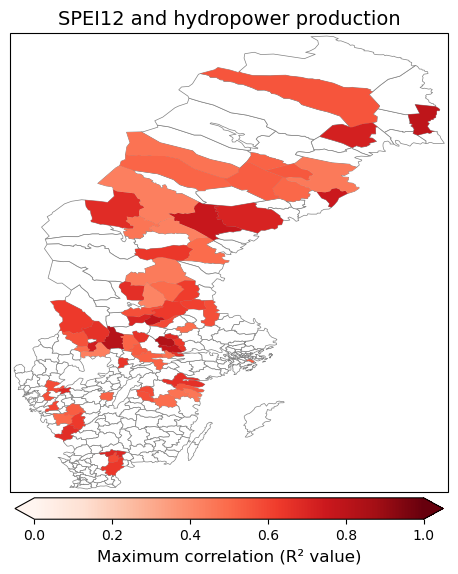

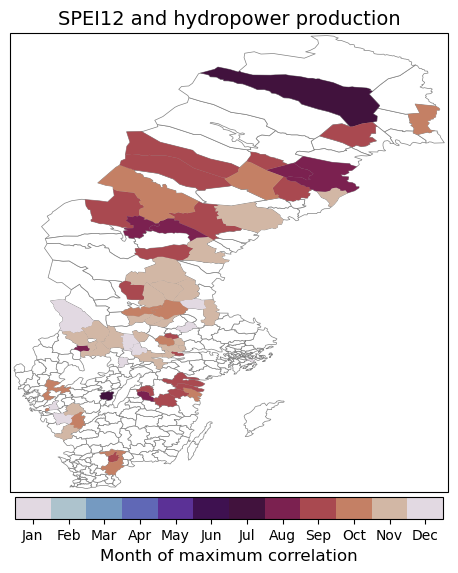

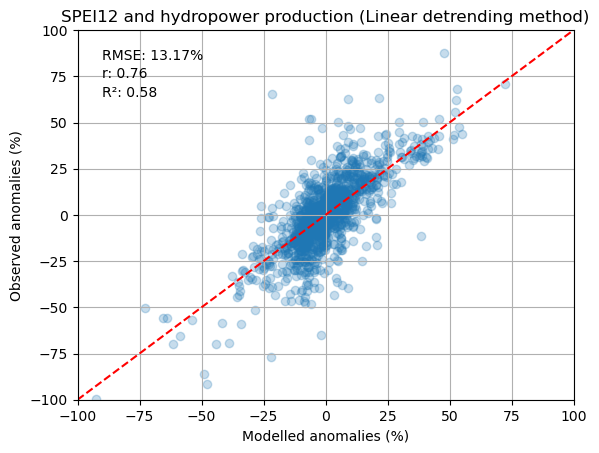

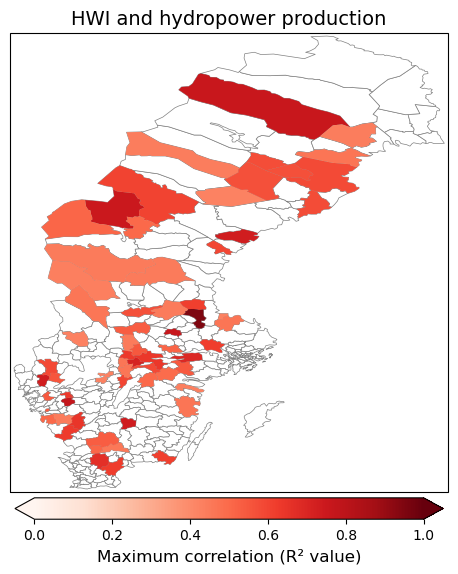

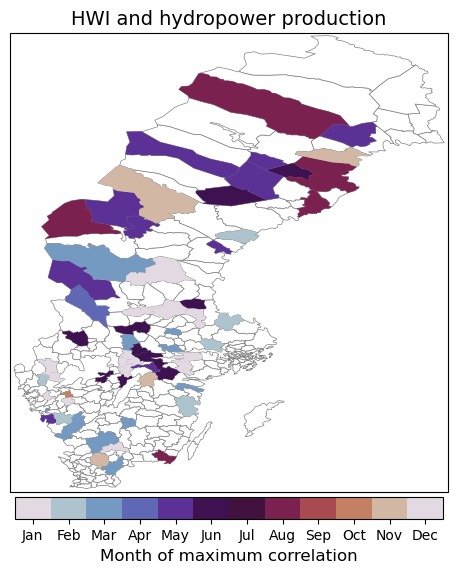

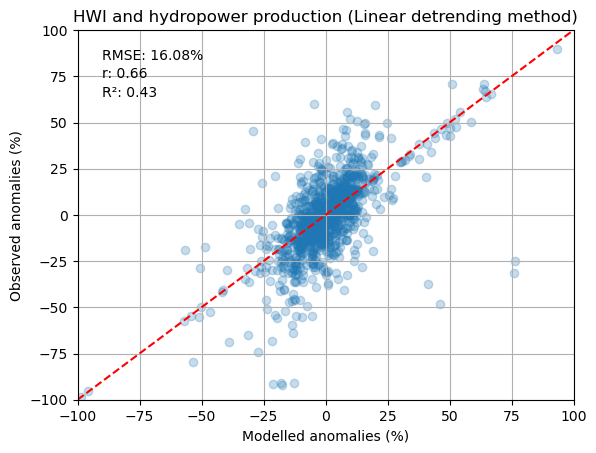

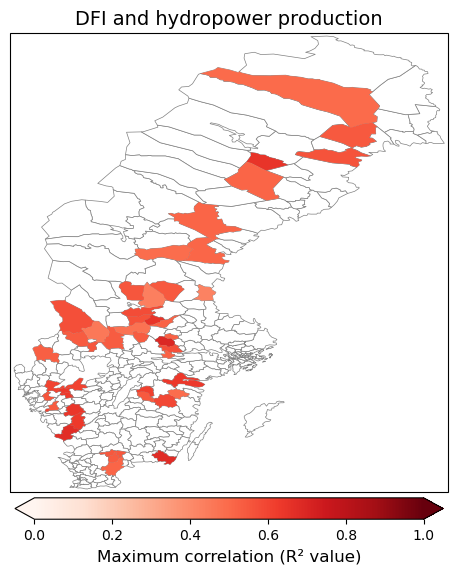

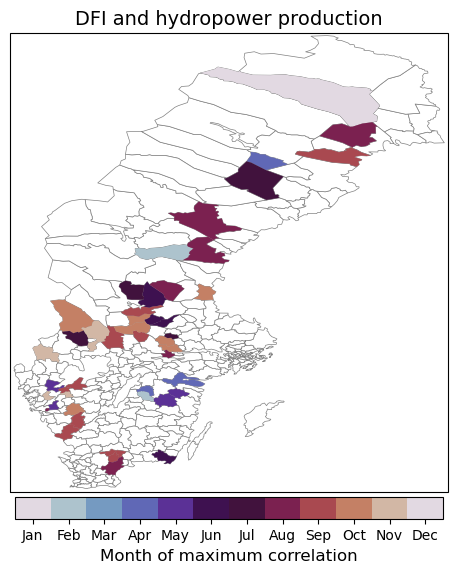

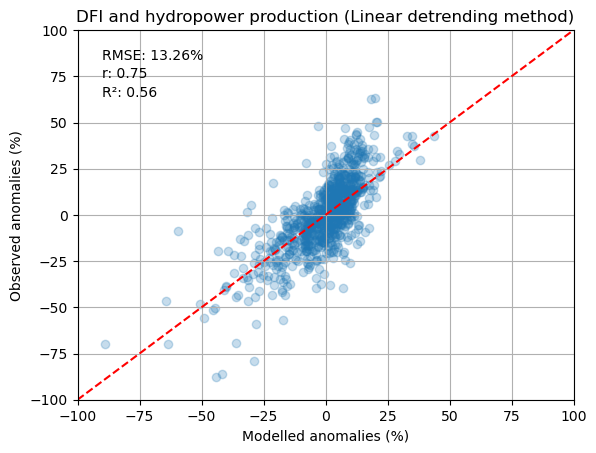

In [15]:
# Batch Runs - Energy
runs_df=pd.read_excel('Variable Runs Municipality.xlsx',
                         'Energy')
runs_df=runs_df.sort_values('hazard_var', ascending=False)
runs_df=runs_df[runs_df['Threshold Type']=='none']
all_corr_df=pd.DataFrame()
all_count_df=pd.DataFrame()
all_saved_data=pd.DataFrame()
trends=['Linear']
runs_df['Count']=np.nan
runs_df['Trend']=np.nan
runs_df['Median R2']=np.nan
runs_df['Aggregation']=1
runs_no_trend=runs_df.copy()
for trend in trends:
    runs_df_trend=runs_no_trend.copy()
    runs_df_trend['Trend']=trend
    runs_df=runs_df.append(runs_df_trend)
runs_df=runs_df.dropna(subset='Trend')
months=[2,3,4,5,6,7,8,9,10,11,12]
runs_no_month=runs_df.copy()
for month in months:
    runs_df_month=runs_no_month.copy()
    runs_df_month['Aggregation']=month
    runs_df=runs_df.append(runs_df_month)
window_frac=0.25 # For LOWESS only
for N in range(len(runs_df)):
    trend= runs_df['Trend'].iloc[N]
    var_imp= runs_df['impact_var'].iloc[N]
    var_haz= runs_df['hazard_var'].iloc[N]
    conversion= runs_df['Conversion'].iloc[N]
    threshold= runs_df['Threshold'].iloc[N]
    t_type= runs_df['Threshold Type'].iloc[N]
    #threshold=0
    agg_type= runs_df['Aggregation'].iloc[N]
    data=read_data(agg_type)
    #agg_type= 'mean'
    print('Hazard variable: '+var_haz)
    print('Impact variable: '+var_imp)
    print('Aggregation type: '+str(agg_type))
    print('Threshold type: '+str(t_type))
    print('Trend: '+str(trend))
    print('Threshold: '+str(threshold))
    corr_df, count_df, mean_r2, median_r2, count, saved_data = correlations(data, var_imp, var_haz, threshold, trend, agg_type)
    runs_df['Mean R2'].iloc[N]=mean_r2
    runs_df['Median R2'].iloc[N]=median_r2
    runs_df['Count'].iloc[N]=count # number of municipality with good results
    all_corr_df=all_corr_df.append(corr_df)
    all_saved_data=all_saved_data.append(saved_data)
    all_count_df=all_count_df.append(count_df)
runs_df.to_excel('Runs_energy_municipalities_months.xlsx')
all_saved_data.to_csv('Results_energy_municipalities_months.csv')
all_corr_df.to_excel('All_correlations_energy_municipalities_months.xlsx')
# Plot graphs of maximum correlations
max_df=pd.DataFrame()
max_df['R2 overall']=np.nan
max_df['RMSE overall']=np.nan
r_squared_list=[]
r_list=[]
p_list=[]
rmse_list=[]
hazvar_list=[]
impvar_list=[]
trend_list=[]
for trend in all_count_df['Trend'].unique():
    for hazvar in all_count_df['Hazard variable'].unique():
        for impvar in all_count_df['Impact variable'].unique():
            hazvar_list.append(hazvar)
            impvar_list.append(impvar)
            trend_list.append(trend)
           # Select all correlations for all municipalities and months by hazard pair and trend type 
            all_corr_df_var=all_corr_df[all_corr_df['Hazard variable']==hazvar]
            all_corr_df_var=all_corr_df_var[all_corr_df_var['Impact variable']==impvar]
            all_corr_df_var=all_corr_df_var[all_corr_df_var['Trend']==trend]
            # Find maximum correlations by month 
            max_corr_agg = all_corr_df_var.groupby(['Municipality','Impact variable', 'Hazard variable', 'Trend']).agg('max').reset_index()
            max_corr_agg = max_corr_agg[max_corr_agg['Correlation']>0]
            # Drop Aggregation Column from max_corr_agg
            max_corr_agg.drop(columns=['Aggregation', 'A', 'B', 'C', 'D', 'p'], inplace=True)
            # Merge max_corr_agg with all_corr_df based on Correlation and Municipality to obtain corresponding Aggregation with maximum correlation
            max_corr_agg = pd.merge(max_corr_agg, all_corr_df, on=['Municipality', 'Impact variable', 'Hazard variable', 'Correlation', 'Trend'], how='left')
            corr_gdf = pd.merge(kommun_shapefile, max_corr_agg, left_on='KnNamn', right_on='Municipality')
            # Next, retrieve yearly impacts based on month with highest correlation 
            max_data= pd.merge(max_corr_agg, all_saved_data, on=['Municipality', 'Impact variable', 'Hazard variable', 'Aggregation', 'Trend'], how='left')
            impvar_name=impact_info[impact_info['var']==impvar]['Variable Name'].values[0]
            hazvar_name=hazard_info[hazard_info['var']==hazvar]['Variable Name'].values[0]
            title= hazvar_name +' and ' + impvar_name.lower()
            plot_map(corr_gdf, 'Correlation', title, 'Maximum correlation (R² value)',
                     lower_bound=0, upper_bound=1, 
                     vcenter=0, cmap_type='Reds', save='no', filename='r2_map_corrs')
            plot_map_months(corr_gdf, 'Aggregation', title, 'Month of maximum correlation',
                     lower_bound=1, upper_bound=13, 
                     vcenter=0, cmap_type='Reds', save='no', filename='r2_map_months')

            # Sample data
            predicted_anomalies = max_data['Predicted anomalies']
            observed_anomalies = max_data['Observed anomalies']
            
            # Step 1: Filter out anomalies that are too large or too low
            predicted_anomalies = np.where((predicted_anomalies > 100) | (predicted_anomalies < -100), np.nan, predicted_anomalies)
            observed_anomalies = np.where((observed_anomalies > 100) | (observed_anomalies < -100), np.nan, observed_anomalies)

            # Step 2: Create a mask for indices where both arrays are non-NaN
            valid_mask = ~np.isnan(predicted_anomalies) & ~np.isnan(observed_anomalies)

            # Step 3: Filter both arrays using the mask
            predicted_anomalies = predicted_anomalies[valid_mask]
            observed_anomalies = observed_anomalies[valid_mask]

            # Calculate mean root square error and R-squared
            r_squared = r2_score(observed_anomalies, predicted_anomalies)
            r_squared_list.append(r_squared)
            r, p_value = pearsonr(observed_anomalies, predicted_anomalies)
            r_list.append(r)
            p_list.append(p_value)
            #print("R-squared:", r_squared)
            mse = mean_squared_error(observed_anomalies, predicted_anomalies)
            rmse = np.sqrt(mse)
            rmse_list.append(rmse)
            # Define limits
            limit = (-100, 100)

            # Plot scatter with transparency
            plt.scatter(predicted_anomalies, observed_anomalies, alpha=0.25)
            plt.xlim(limit)
            plt.ylim(limit)
            plt.xlabel('Modelled anomalies (%)')
            plt.ylabel('Observed anomalies (%)')
            plt.title(title+' ('+trend+' detrending method)')
            # Plot diagonal line
            plt.plot(limit, limit, color='red', linestyle='--')

            # Add text boxes for mean root square error and R-squared
            plt.text(0.05, 0.95, f'RMSE: {rmse:.2f}%', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
            plt.text(0.05, 0.90, f'r: {r:.2f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
            plt.text(0.05, 0.85, f'R²: {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
            plt.grid(True)
            plt.show()

# Save results
max_df['Impact variable']=impvar_list
max_df['Hazard variable']=hazvar_list
max_df['Trend']=trend_list
max_df['R2 overall']=r_squared_list
max_df['R overall']=r_list
max_df['RMSE overall']=rmse_list
max_df['p overall']=p_list
max_df.to_excel('Correlations_energy_municipalities_months.xlsx')

In [16]:
# Merge all results for plotting
import pandas as pd
all_corr_df=pd.read_excel('All_correlations_energy_municipalities_months.xlsx')
all_corr_df=all_corr_df.append(pd.read_excel('All_correlations_water_municipalities_months.xlsx'))
all_corr_df=all_corr_df.append(pd.read_excel('All_correlations_food_municipalities_months.xlsx'))
all_saved_data=pd.read_csv('Results_energy_municipalities_months.csv')
all_saved_data=all_saved_data.append(pd.read_csv('Results_water_municipalities_months.csv'))
all_saved_data=all_saved_data.append(pd.read_csv('Results_food_municipalities_months.csv'))
all_corr_df=all_corr_df.drop(columns=['Unnamed: 0'])
all_saved_data=all_saved_data.drop(columns=['Unnamed: 0'])
impact_info=pd.read_excel('Variable List.xlsx','Impact')
hazard_info=pd.read_excel('Variable List.xlsx', 'Hazard')

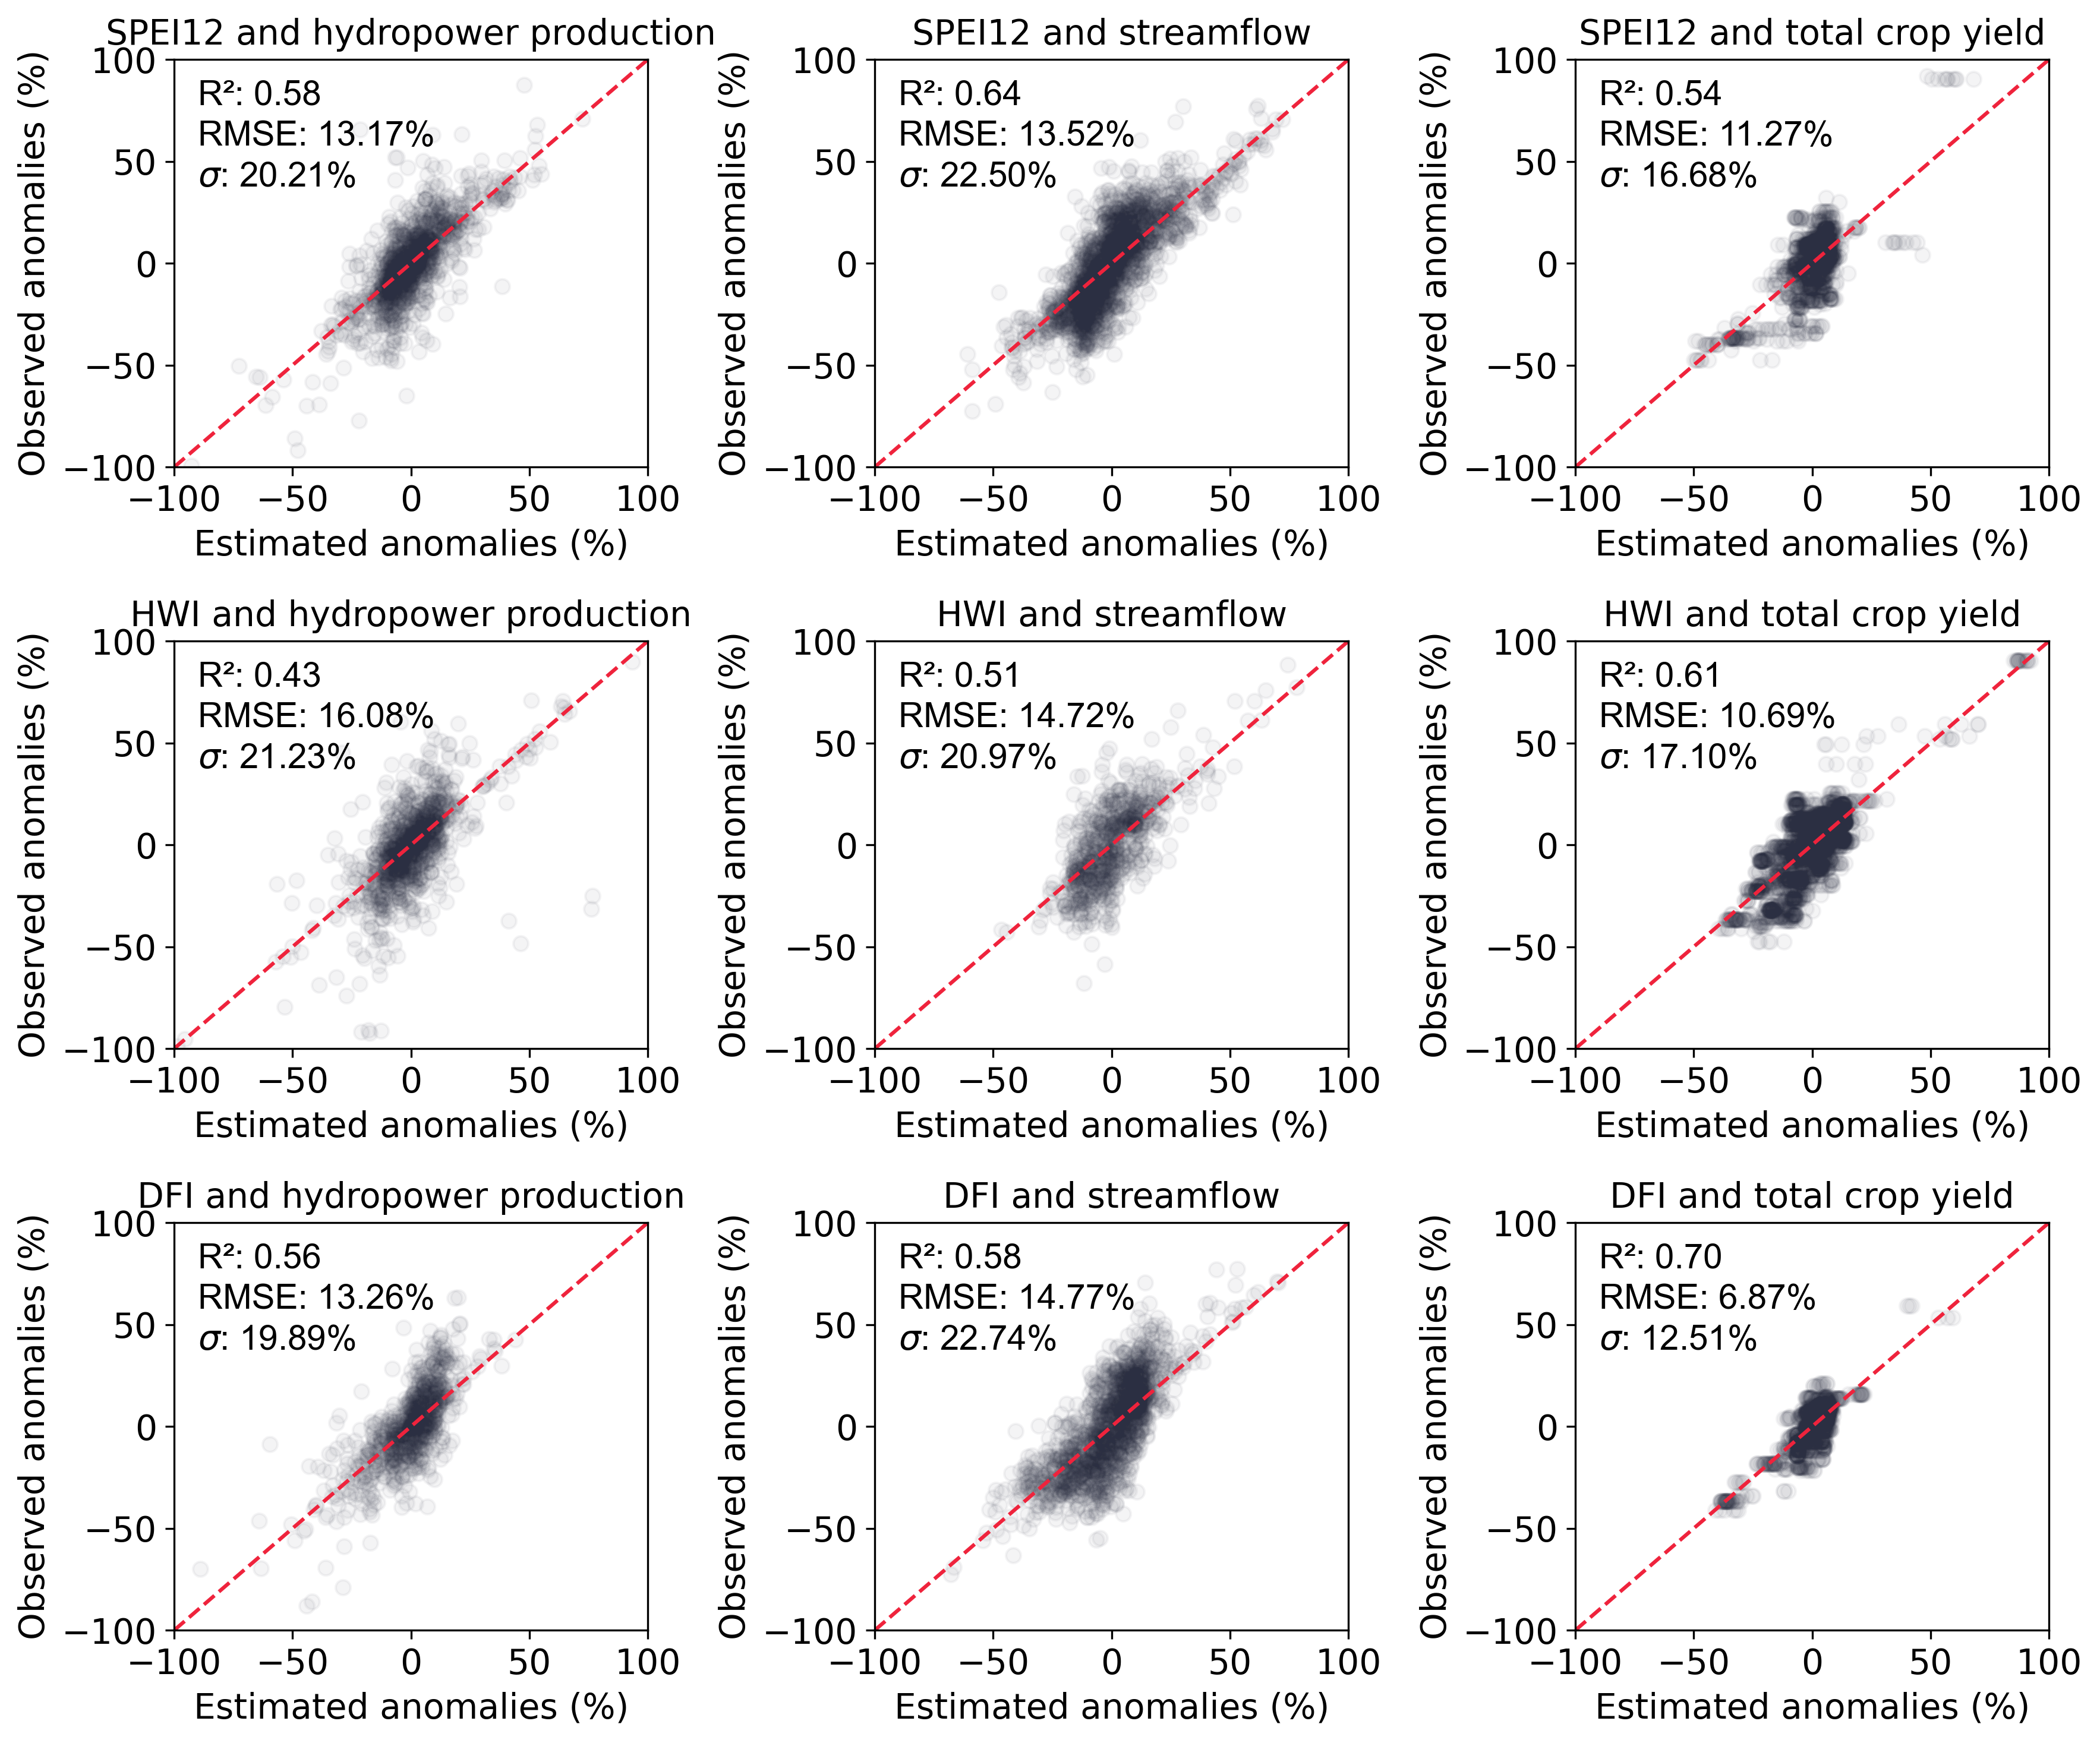

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
plt.rcdefaults()
def plot_associations(all_corr_df, impact_info, hazard_info, all_saved_data):
    fig, axes = plt.subplots(3, 3, figsize=(12, 10), dpi=300)
    axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

    # Set font properties for publication quality
    SIZE_DEFAULT = 14
    SIZE_LARGE = 14
    plt.rc("font", family="Arial")
    #plt.rc('font', serif='Helvetica Neue') 
    plt.rc("font", size=SIZE_DEFAULT)
    plt.rc("axes", titlesize=SIZE_LARGE)
    plt.rc("axes", labelsize=SIZE_LARGE)
    plt.rc("xtick", labelsize=SIZE_DEFAULT)
    plt.rc("ytick", labelsize=SIZE_DEFAULT)

    # Define a color palette
    colors = ["#2B2F42", "#EF233C", "#8D99AE"]

    # Initialize lists to store results
    r_squared_list = []

    rmse_list = []
    hazvar_list = []
    impvar_list = []
    trend_list = []

    # Detrending method
    trends = ['Linear']

    # Counter for subplot index
    plot_index = 0
    impvars = all_corr_df['Impact variable'].unique()
    impvars = impvars[impvars != 'groundwater']
    impvars = impvars[impvars != 'livestock']
    hazvars = all_corr_df['Hazard variable'].unique()

    for trend in trends:
        for hazvar in hazvars:
            for impvar in impvars:
                hazvar_list.append(hazvar)
                impvar_list.append(impvar)
                trend_list.append(trend)

                # Filter data for the specific hazard-impact pair and trend
                all_corr_df_var = all_corr_df[(all_corr_df['Hazard variable'] == hazvar) & 
                                              (all_corr_df['Impact variable'] == impvar) & 
                                              (all_corr_df['Trend'] == trend)]

                # Find maximum correlations by month
                max_corr_agg = all_corr_df_var.groupby(['Municipality', 'Impact variable', 'Hazard variable', 'Trend']).agg('max').reset_index()
                max_corr_agg = max_corr_agg[max_corr_agg['Correlation'] > 0]
                max_corr_agg = max_corr_agg.drop(columns=['Aggregation', 'A', 'B', 'C', 'D', 'ATE'], errors='ignore')
                max_corr_agg = pd.merge(max_corr_agg, all_corr_df, on=['Municipality', 'Impact variable', 'Hazard variable', 'Correlation', 'Trend'], how='left')

                corr_gdf = pd.merge(kommun_shapefile, max_corr_agg, left_on='KnNamn', right_on='Municipality')

                impvar_name = impact_info[impact_info['var'] == impvar]['Variable Name'].values[0]
                hazvar_name = hazard_info[hazard_info['var'] == hazvar]['Variable Name'].values[0]
                title = f'{hazvar_name} and {impvar_name.lower()}'

                # Retrieve data
                max_data = pd.merge(max_corr_agg, all_saved_data, on=['Municipality', 'Impact variable', 'Hazard variable', 'Aggregation', 'Trend'], how='left')
                predicted_anomalies = max_data['Predicted anomalies']
                observed_anomalies = max_data['Observed anomalies']

                # Filter anomalies
                predicted_anomalies = np.where((predicted_anomalies > 100) | (predicted_anomalies < -100), np.nan, predicted_anomalies)
                observed_anomalies = np.where((observed_anomalies > 100) | (observed_anomalies < -100), np.nan, observed_anomalies)

                # Create mask for valid data
                valid_mask = ~np.isnan(predicted_anomalies) & ~np.isnan(observed_anomalies)
                predicted_anomalies = predicted_anomalies[valid_mask]
                observed_anomalies = observed_anomalies[valid_mask]

                # Calculate RMSE and R-squared
                r_squared = r2_score(observed_anomalies, predicted_anomalies)
                #r, p_value = pearsonr(observed_anomalies, predicted_anomalies) # not suitable for nonlinear regression
                rmse = np.sqrt(mean_squared_error(observed_anomalies, predicted_anomalies))
                std = np.std(observed_anomalies)

                r_squared_list.append(r_squared)
                rmse_list.append(rmse)

                # Define plot limits
                limit = (-100, 100)

                # Plot scatter with transparency
                ax = axes[plot_index]
                ax.scatter(predicted_anomalies, observed_anomalies, alpha=0.05, color=colors[0])
                ax.plot(limit, limit, color=colors[1], linestyle='--', linewidth=1.5)

                # Set axis labels and title
                ax.set_xlim(limit)
                ax.set_ylim(limit)
                ax.set_xlabel('Estimated anomalies (%)', fontsize=SIZE_LARGE)
                ax.set_ylabel('Observed anomalies (%)', fontsize=SIZE_LARGE)
                ax.tick_params(axis='both', which='major', labelsize=SIZE_DEFAULT)
                ax.set_title(title)

                # Add text box for statistics
                ax.text(0.05, 0.95, f'R²: {r_squared:.2f}', transform=ax.transAxes, fontsize=SIZE_DEFAULT, verticalalignment='top')
                #ax.text(0.05, 0.85, f'r: {r:.2f}', transform=ax.transAxes, fontsize=SIZE_DEFAULT, verticalalignment='top')
                ax.text(0.05, 0.85, f'RMSE: {rmse:.2f}%', transform=ax.transAxes, fontsize=SIZE_DEFAULT, verticalalignment='top')
                ax.text(0.05, 0.75, f'$\sigma$: {std:.2f}%', transform=ax.transAxes, fontsize=SIZE_DEFAULT, verticalalignment='top')

                # Remove gridlines
                ax.grid(False)

                # Move to the next subplot
                plot_index += 1

    # Adjust layout and save figure
    plt.tight_layout()
    plt.savefig('fig_models.svg', dpi=300, bbox_inches='tight')
    plt.show()

plot_associations(all_corr_df, impact_info, hazard_info, all_saved_data)
